In [434]:
%matplotlib inline

import os
from collections import Counter, OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import seaborn as sns
import pandas as pd
pd.options.mode.use_inf_as_na = True

In [435]:
metafilename = 'training_set_metadata.csv'
metadata = pd.read_csv(metafilename)
metadata.head(1)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [436]:
#Load previously generated cesium feature file
featurefile = 'C:/Users/Greg/Documents/Personal/PLAsTiCC/plasticc_featuretablemore.npz'
featuretable, _ = featurize.load_featureset(featurefile)
featuretable = featuretable.reset_index(level=0)
featuretable.head()

feature index all_times_nhist_numpeaks                           \
channel                              0    1    2    3    4    5   
0         615                     18.0  3.0  3.0  3.0  3.0  4.0   
1         713                     15.0  3.0  3.0  3.0  3.0  3.0   
2         730                     16.0  7.0  7.0  7.0  7.0  7.0   
3         745                     18.0  4.0  4.0  4.0  4.0  4.0   
4        1124                     18.0  3.0  3.0  3.0  3.0  4.0   

feature all_times_nhist_peak_val                       ...           std  \
channel                        0         1         2   ...             5   
0                       0.006097  0.004050  0.004050   ...    292.182295   
1                       0.006491  0.004738  0.004738   ...      7.030448   
2                       0.006176  0.004240  0.004240   ...     13.201397   
3                       0.005318  0.004374  0.004374   ...     25.822133   
4                       0.006097  0.004050  0.004050   ...     21.245772   

feature weighted_average                                                 \
channel                0           1           2           3          4   
0             -17.061118 -212.397193 -102.220639 -101.206639 -54.744845   
1              -3.500958   -1.322397   -1.030469   -1.382941  -1.407879   
2              -0.016423   -0.034170    2.059833    2.988513   4.486335   
3               1.176322    3.652226    6.716857   12.514694  12.247387   
4               0.824380    3.617169    7.842645    8.830427   8.463856   

feature             mwebv       z    zerr  
channel          5                         
0       -59.688379  0.017  0.0000  0.0000  
1        -1.876399  0.007  1.6267  0.2552  
2         5.057690  0.021  0.2262  0.0157  
3         8.760515  0.007  0.2813  1.1523  
4         5.602845  0.024  0.2415  0.0176  

[5 rows x 130 columns]

In [437]:
#Flatten index of the column names
old_names = featuretable.columns.values
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])
pbnames = list(pbmap.values())
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]

In [438]:
featuretable.columns = featuretable.columns.droplevel(0)
featuretable.columns = new_names
featuretable.head()

,index_meta,all_times_nhist_numpeaks_u,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_i,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,all_times_nhist_peak_val_u,all_times_nhist_peak_val_g,all_times_nhist_peak_val_r,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
0,615,18.0,3.0,3.0,3.0,3.0,4.0,0.006097,0.004050,0.004050,...,292.182295,-17.061118,-212.397193,-102.220639,-101.206639,-54.744845,-59.688379,0.017,0.0000,0.0000
1,713,15.0,3.0,3.0,3.0,3.0,3.0,0.006491,0.004738,0.004738,...,7.030448,-3.500958,-1.322397,-1.030469,-1.382941,-1.407879,-1.876399,0.007,1.6267,0.2552
2,730,16.0,7.0,7.0,7.0,7.0,7.0,0.006176,0.004240,0.004240,...,13.201397,-0.016423,-0.034170,2.059833,2.988513,4.486335,5.057690,0.021,0.2262,0.0157
3,745,18.0,4.0,4.0,4.0,4.0,4.0,0.005318,0.004374,0.004374,...,25.822133,1.176322,3.652226,6.716857,12.514694,12.247387,8.760515,0.007,0.2813,1.1523
4,1124,18.0,3.0,3.0,3.0,3.0,4.0,0.006097,0.004050,0.004050,...,21.245772,0.824380,3.617169,7.842645,8.830427,8.463856,5.602845,0.024,0.2415,0.0176


In [439]:
#Rename the object Id column to enable a merge:
featuretable = featuretable.rename(columns={"index_meta":"object_id"})
featuretable['object_id'] = featuretable.object_id.astype('int32')

In [440]:
df = pd.merge(metadata,featuretable, on="object_id")
df.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,...,292.182295,-17.061118,-212.397193,-102.220639,-101.206639,-54.744845,-59.688379,0.017,0.0000,0.0000
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,...,7.030448,-3.500958,-1.322397,-1.030469,-1.382941,-1.407879,-1.876399,0.007,1.6267,0.2552
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,...,13.201397,-0.016423,-0.034170,2.059833,2.988513,4.486335,5.057690,0.021,0.2262,0.0157
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,...,25.822133,1.176322,3.652226,6.716857,12.514694,12.247387,8.760515,0.007,0.2813,1.1523
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,...,21.245772,0.824380,3.617169,7.842645,8.830427,8.463856,5.602845,0.024,0.2415,0.0176


In [441]:
#One KNN model will treat only extragalactic sources, and one will 
#treat only galactic sources, so I'll split them up here:
egalmask = df['hostgal_specz'] != 0
extragal = df[egalmask]
extragal.groupby('target').agg('count')

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
target,,,,,,,,,,,,,,,,,,,,,
15,495,495,495,495,495,495,495,495,495,495,...,495,495,495,495,495,495,495,495,495,495
42,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,...,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193
52,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
62,484,484,484,484,484,484,484,484,484,484,...,484,484,484,484,484,484,484,484,484,484
64,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
67,208,208,208,208,208,208,208,208,208,208,...,208,208,208,208,208,208,208,208,208,208
88,370,370,370,370,370,370,370,370,370,370,...,370,370,370,370,370,370,370,370,370,370
90,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313,...,2313,2313,2313,2313,2313,2313,2313,2313,2313,2313
95,175,175,175,175,175,175,175,175,175,175,...,175,175,175,175,175,175,175,175,175,175


In [442]:
gal = df[~egalmask]
gal.groupby('target').agg('count')

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,std_Y,weighted_average_u,weighted_average_g,weighted_average_r,weighted_average_i,weighted_average_z,weighted_average_Y,mwebv_meta,z_meta,zerr_meta
target,,,,,,,,,,,,,,,,,,,,,
6,151,151,151,151,151,151,151,151,151,0,...,151,151,151,151,151,151,151,151,151,151
16,924,924,924,924,924,924,924,924,924,0,...,924,924,924,924,924,924,924,924,924,924
53,30,30,30,30,30,30,30,30,30,0,...,30,30,30,30,30,30,30,30,30,30
65,981,981,981,981,981,981,981,981,981,0,...,981,981,981,981,981,981,981,981,981,981
92,239,239,239,239,239,239,239,239,239,0,...,239,239,239,239,239,239,239,239,239,239


In [443]:
#Before creating train/test splits, we need to remove or impute NaN values
nans = pd.DataFrame(gal.isnull().sum(axis=0), columns=["count"])
nans[nans['count']>0]

,count
distmod,2325
avg_double_to_single_step_u,202
avg_double_to_single_step_g,117
avg_double_to_single_step_r,115
avg_double_to_single_step_i,148
avg_double_to_single_step_z,1
avg_double_to_single_step_Y,148
fold2P_slope_10percentile_u,127
fold2P_slope_10percentile_g,105
fold2P_slope_10percentile_r,3


In [444]:
#For now, I'll drop any column with a nan
gal = gal.dropna(how='any', axis=1)
gal.shape

(2325, 121)

In [445]:
#similar for extragalactic issues:
nans = pd.DataFrame(extragal.isnull().sum(axis=0), columns=["count"])
nans[nans['count']>0]

,count
avg_double_to_single_step_u,714
avg_double_to_single_step_g,324
avg_double_to_single_step_r,323
avg_double_to_single_step_i,399
avg_double_to_single_step_z,6
avg_double_to_single_step_Y,399
fold2P_slope_10percentile_u,269
fold2P_slope_10percentile_g,148
fold2P_slope_10percentile_r,11
fold2P_slope_10percentile_i,13


In [446]:
#For now, I'll drop any column with a nan
extragal = extragal.dropna(how='any', axis=1)
extragal.shape

(5523, 122)

In [447]:
#Split X,Y
galX = gal.drop('target', axis=1)
galY = gal['target']
egalX = extragal.drop('target', axis=1)
egalY = extragal['target']

In [448]:
#Create Train/Test splits
galX_train, galX_test, galY_train, galY_test = train_test_split(
    galX, galY, test_size=0.5)

egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    egalX, egalY, test_size=0.5)

In [449]:
#First, galactic objects
galknn = KNeighborsClassifier(n_neighbors=5)
galknn.fit(galX_train, galY_train)

galknn.score(galX_test, galY_test)

0.41530524505588995

In [450]:
#not great, let's try extragal
egalknn = KNeighborsClassifier(n_neighbors=5)
egalknn.fit(egalX_train, egalY_train)

egalknn.score(egalX_test, egalY_test)

0.30159304851556845

# Ok, so just blindly using a bunch of cesium features wasn't helpful. Here's some visualizations intended to help narrow down:

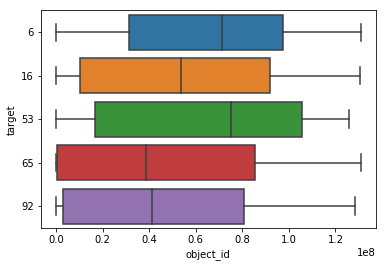

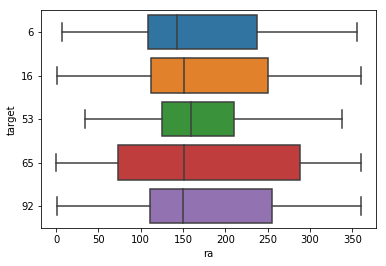

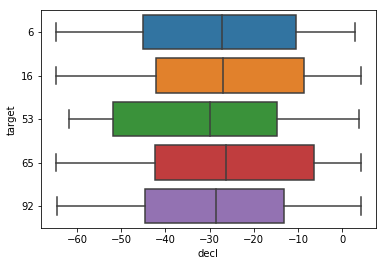

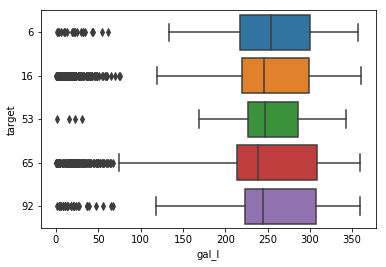

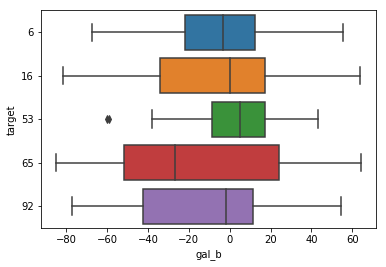

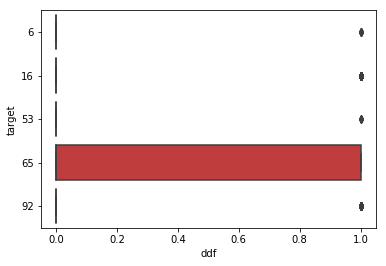

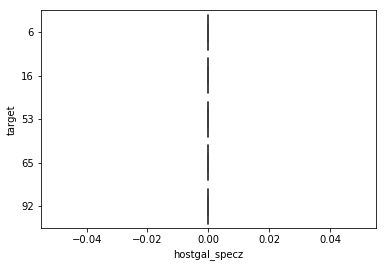

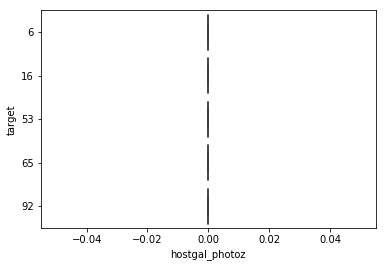

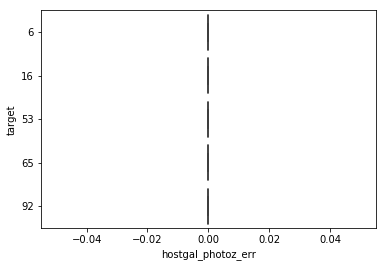

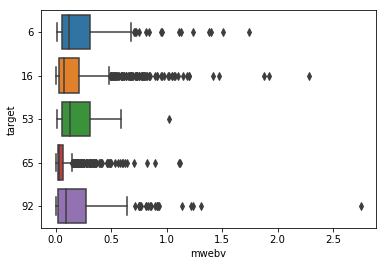

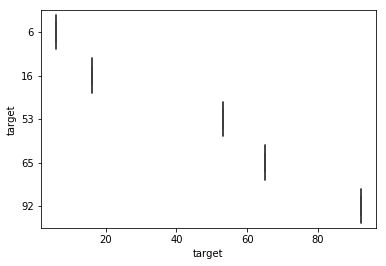

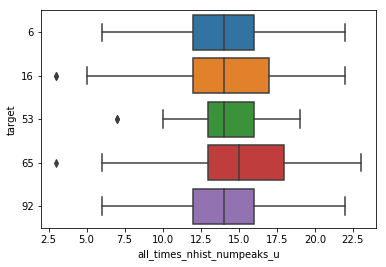

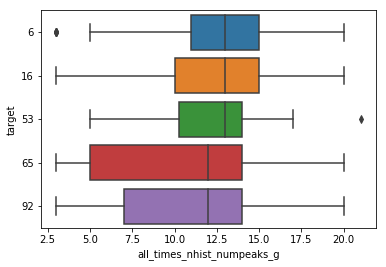

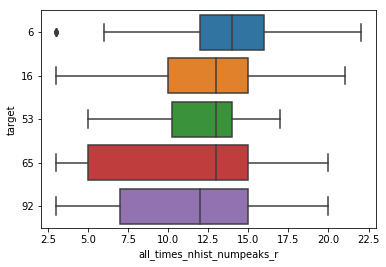

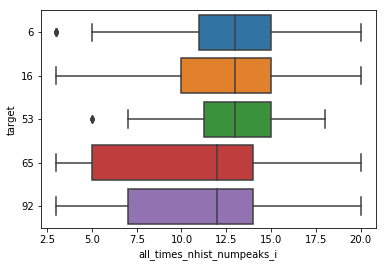

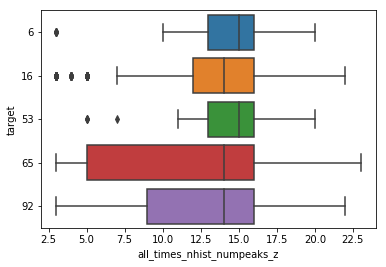

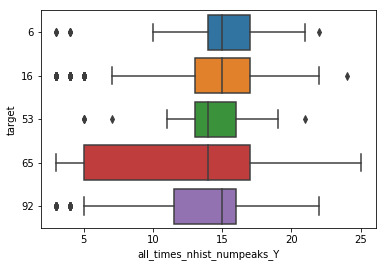

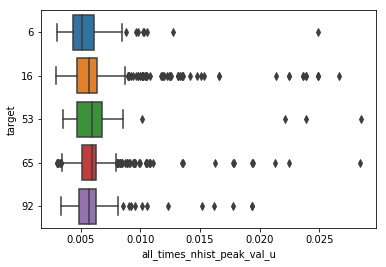

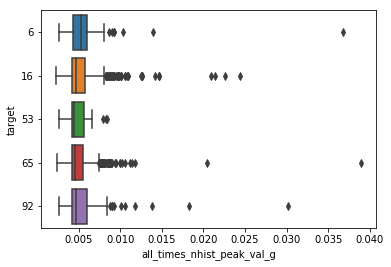

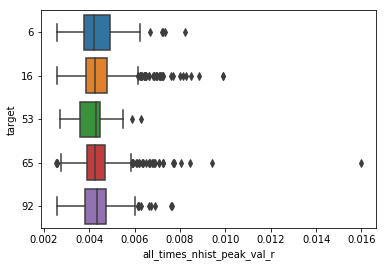

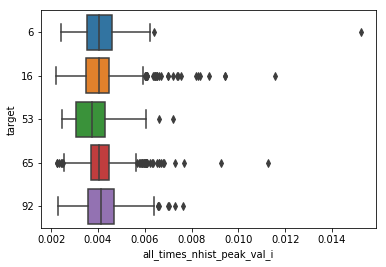

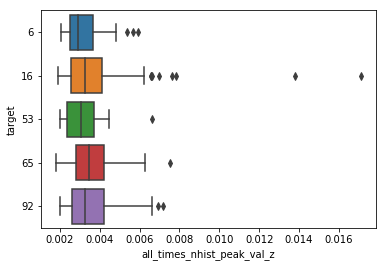

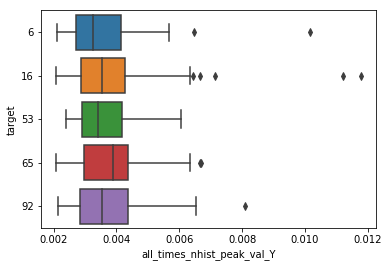

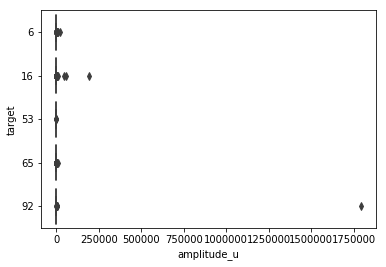

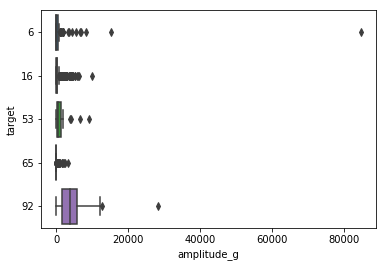

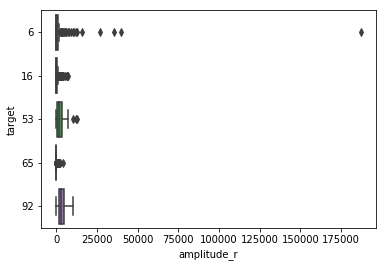

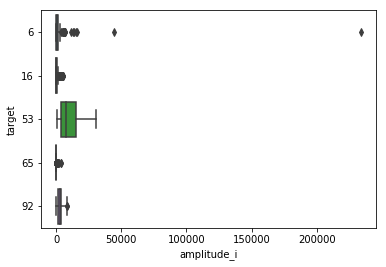

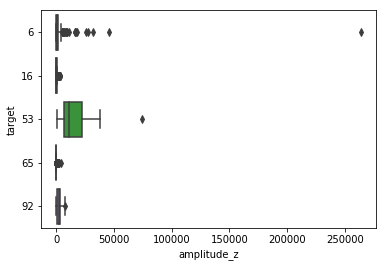

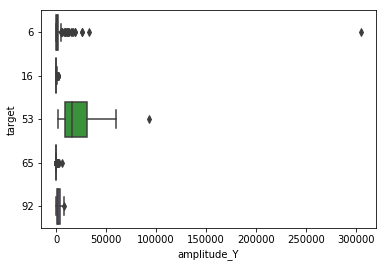

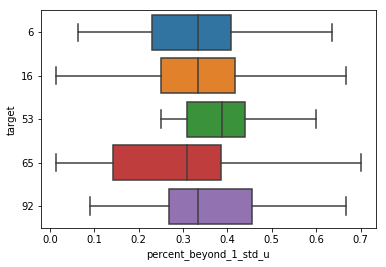

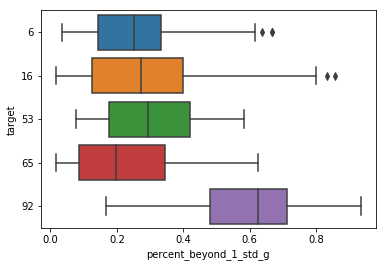

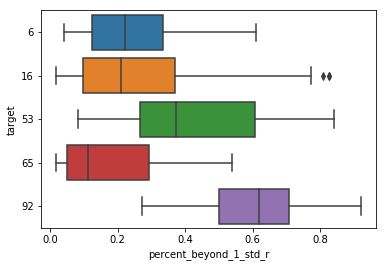

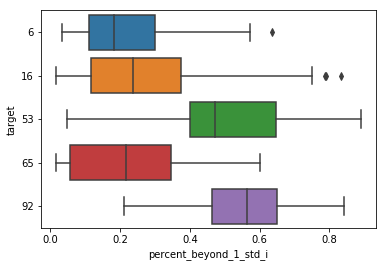

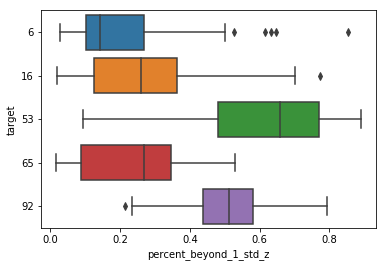

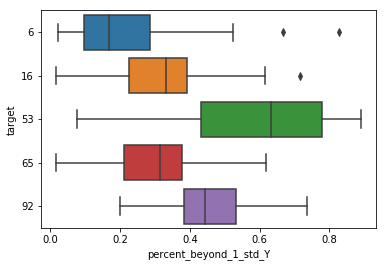

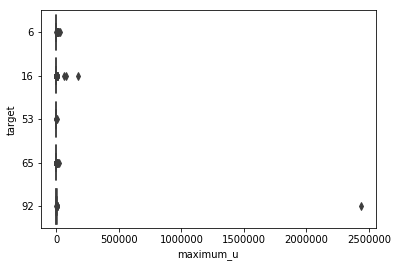

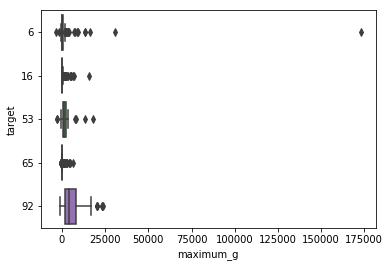

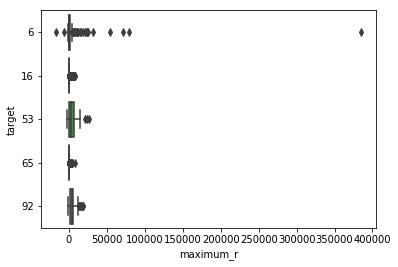

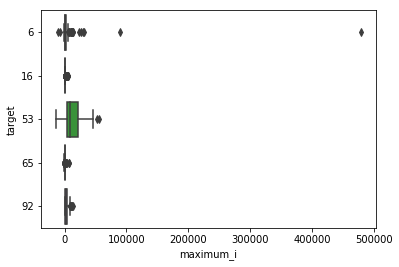

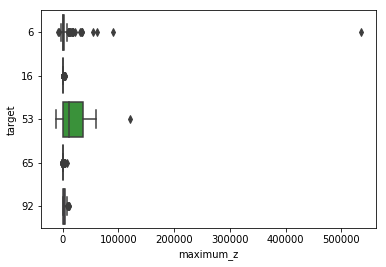

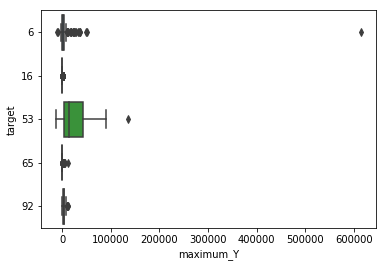

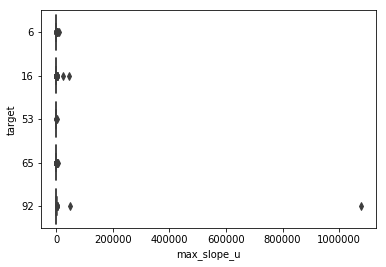

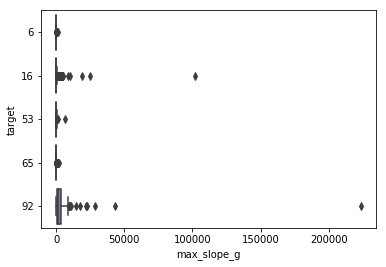

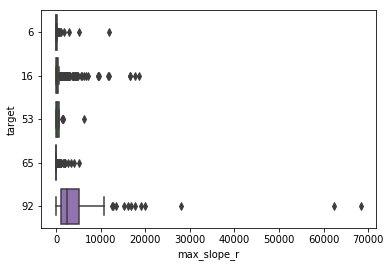

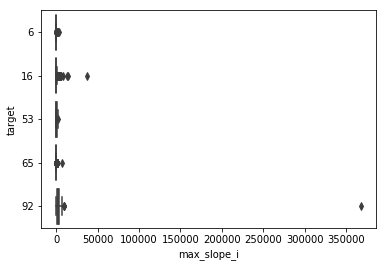

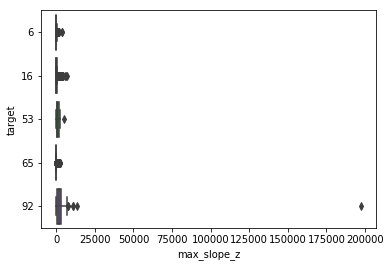

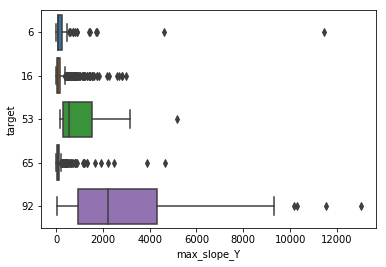

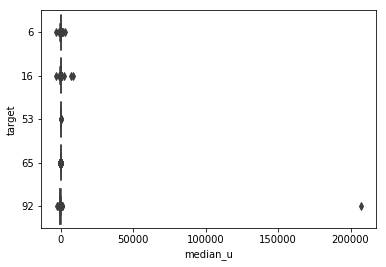

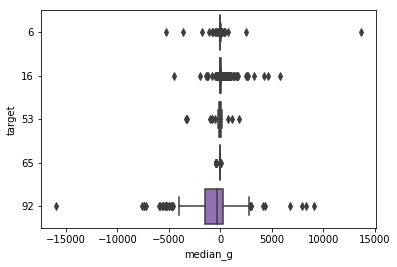

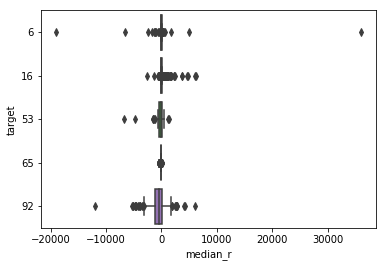

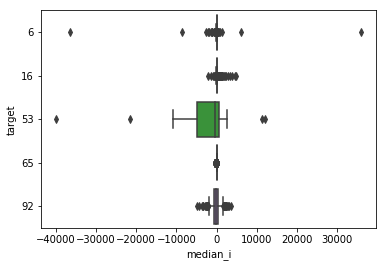

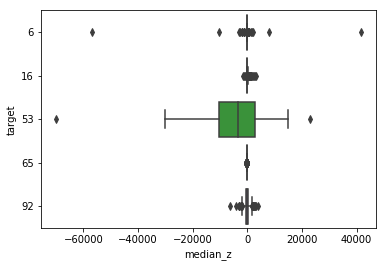

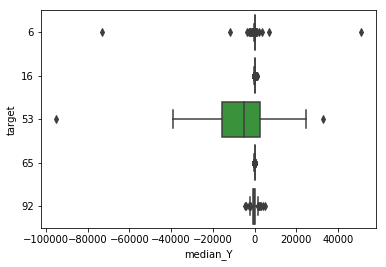

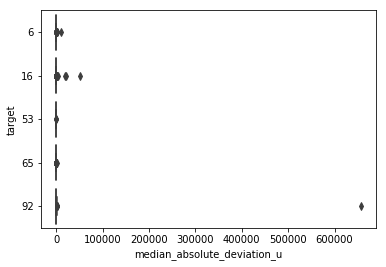

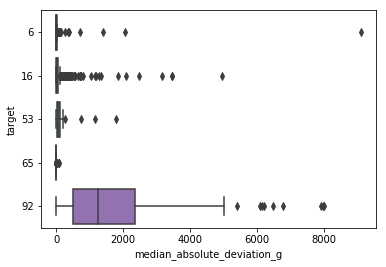

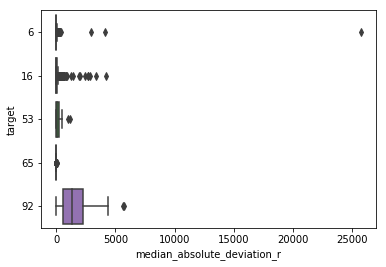

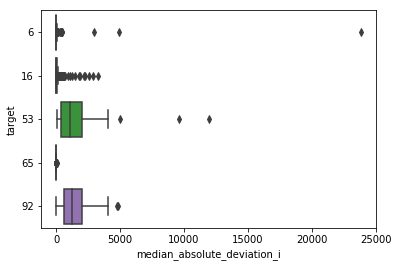

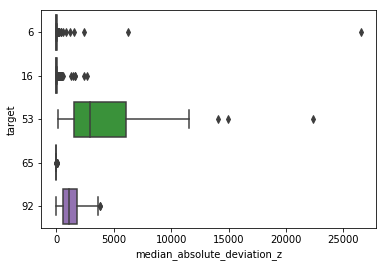

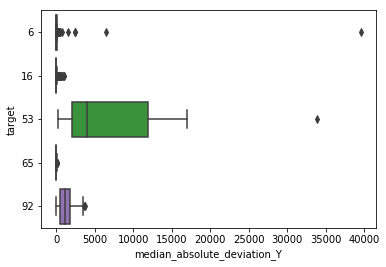

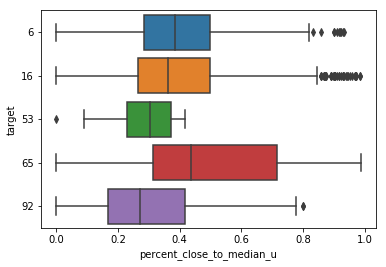

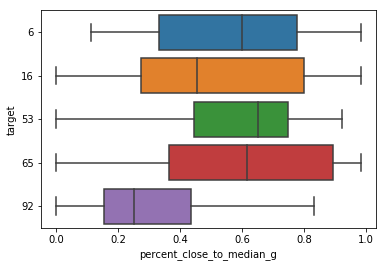

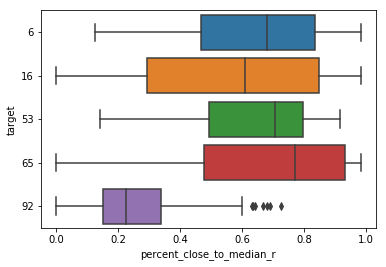

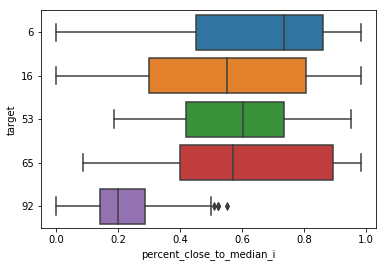

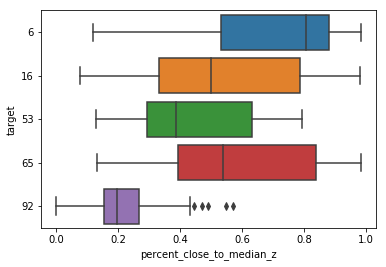

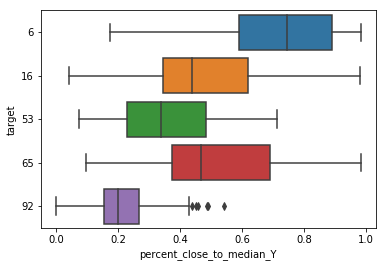

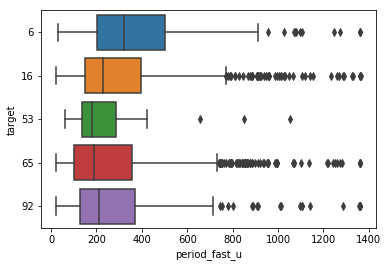

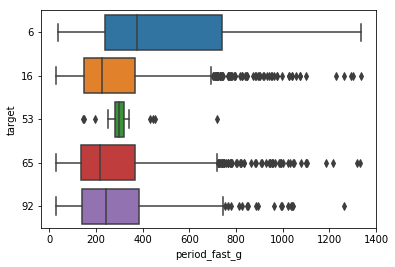

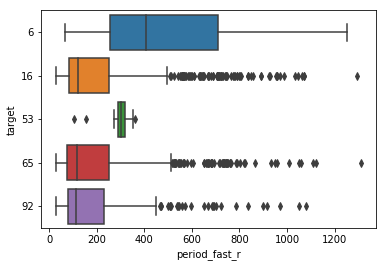

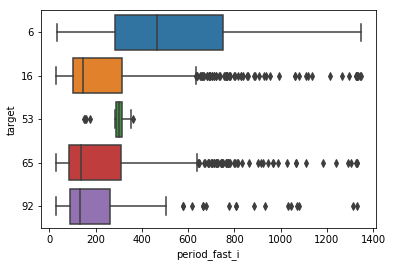

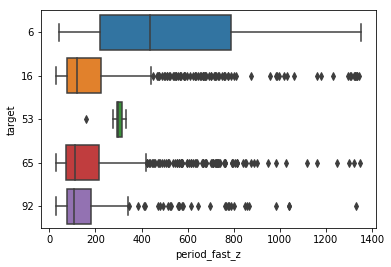

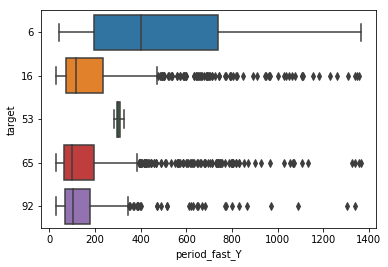

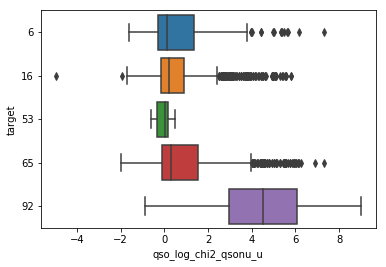

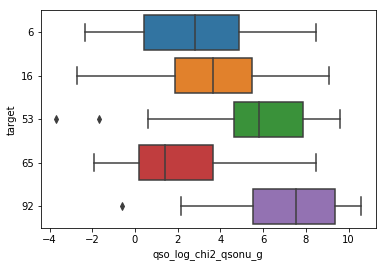

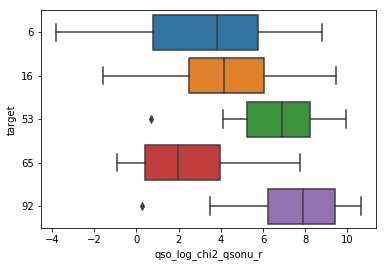

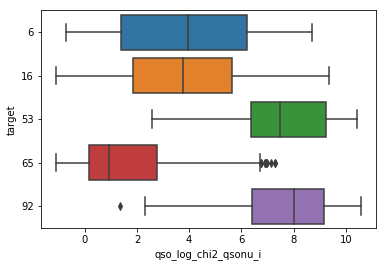

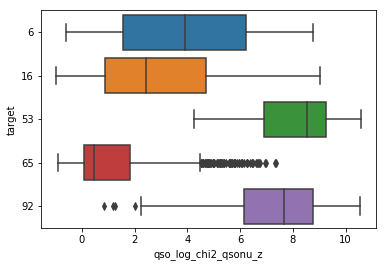

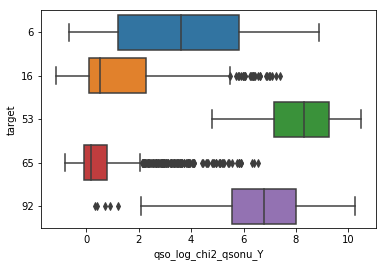

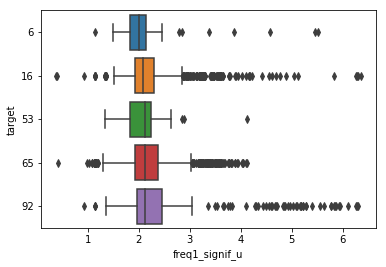

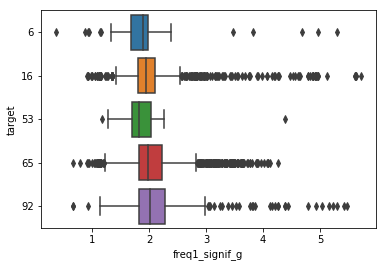

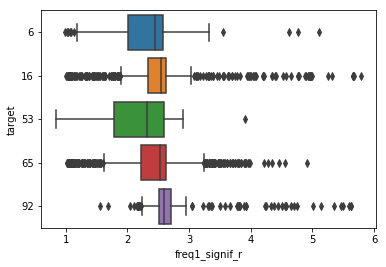

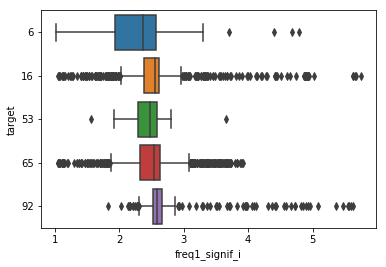

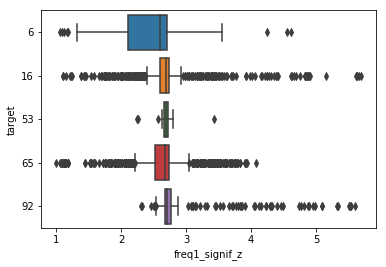

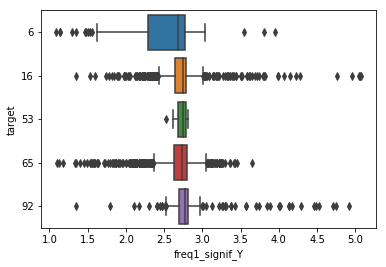

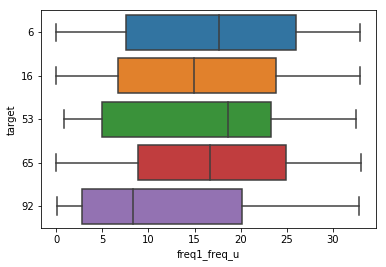

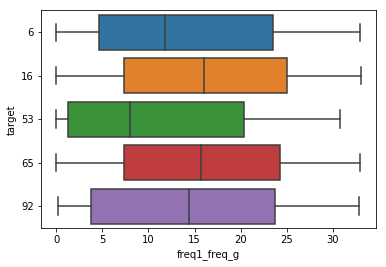

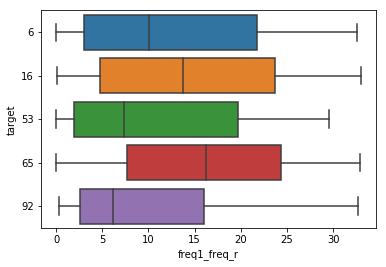

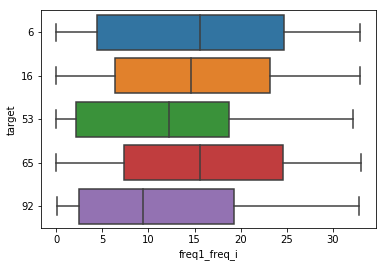

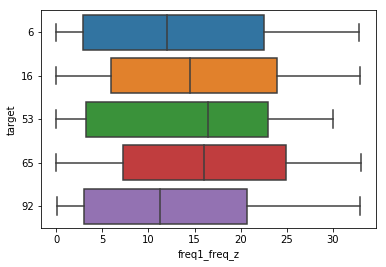

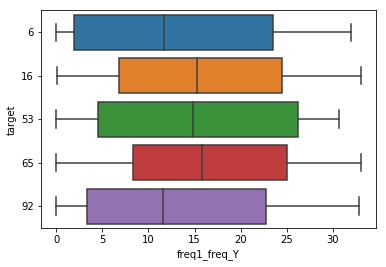

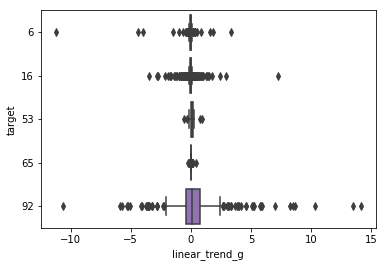

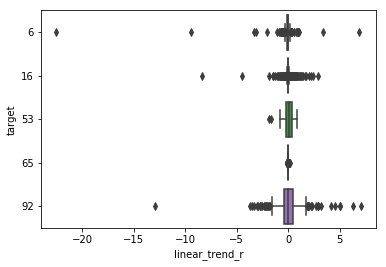

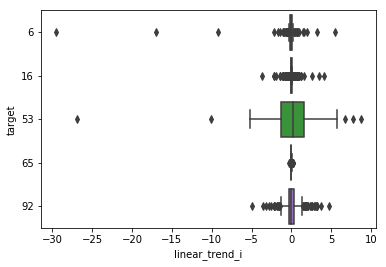

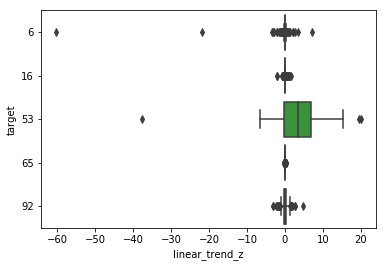

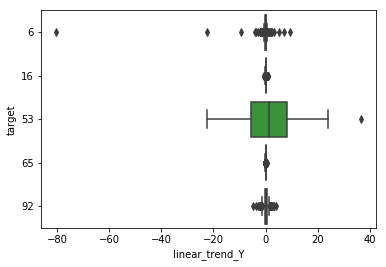

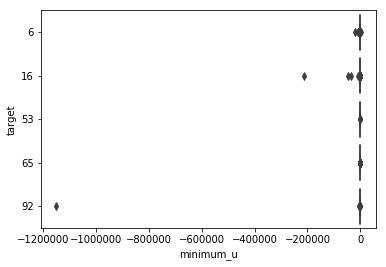

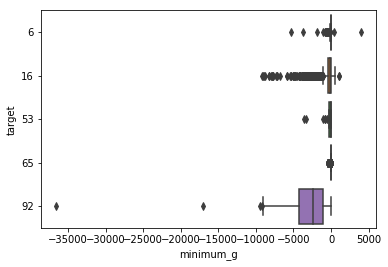

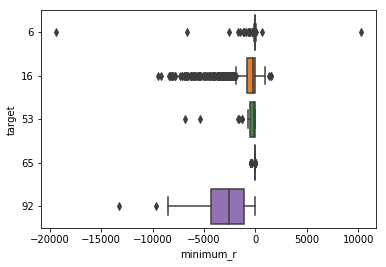

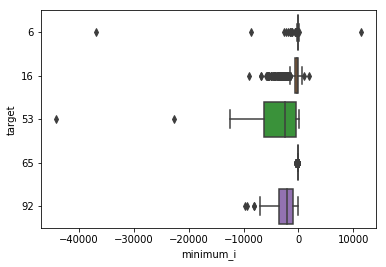

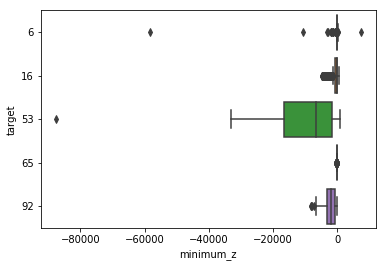

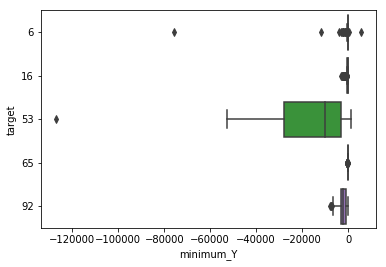

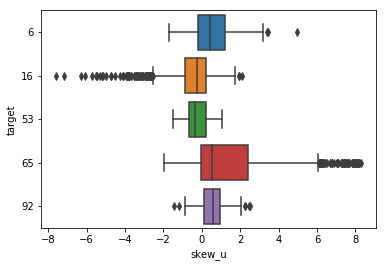

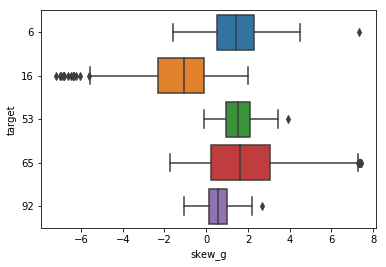

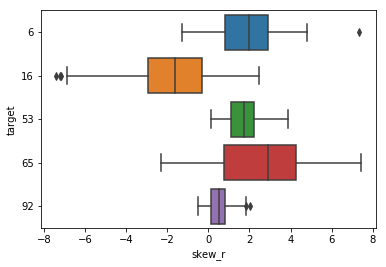

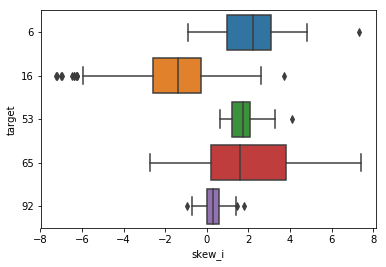

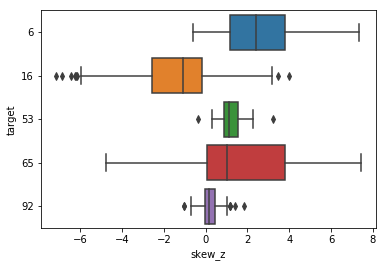

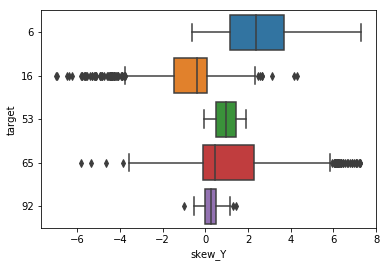

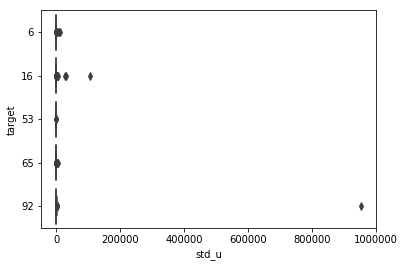

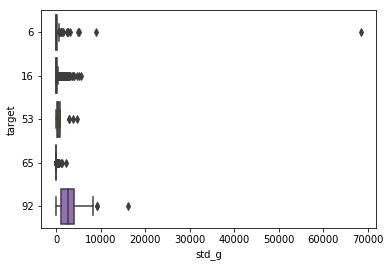

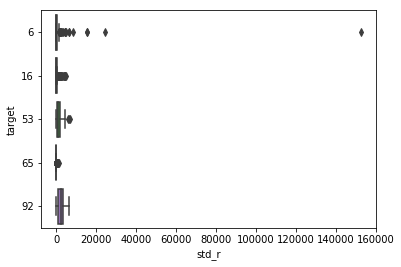

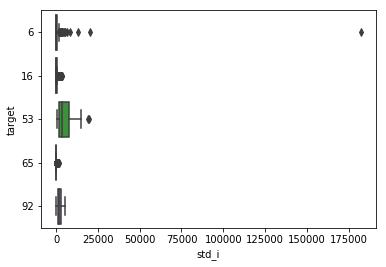

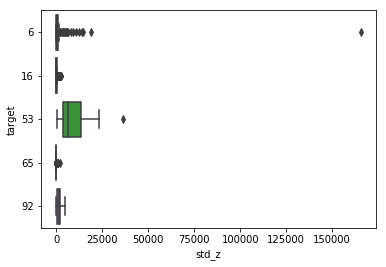

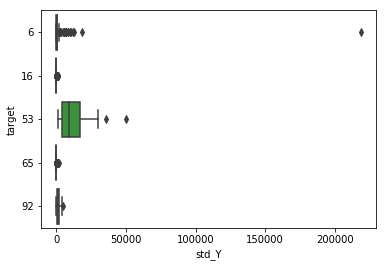

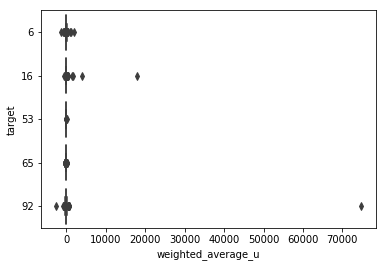

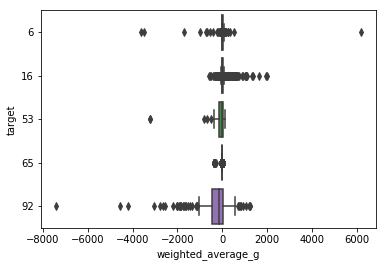

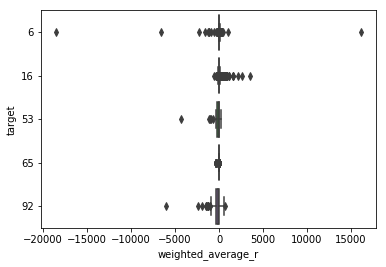

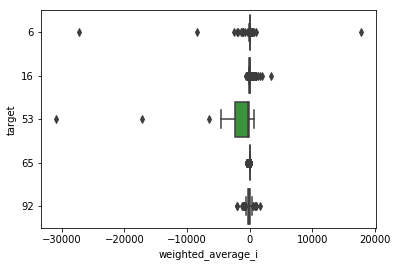

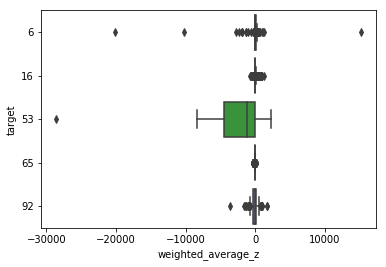

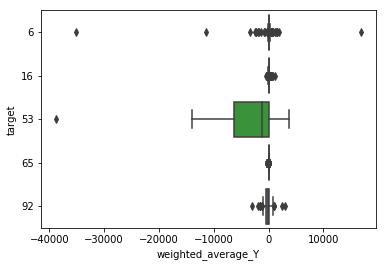

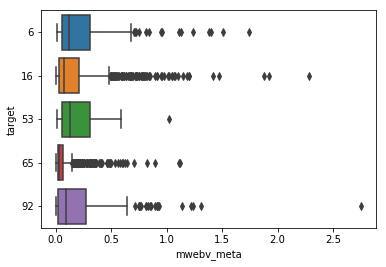

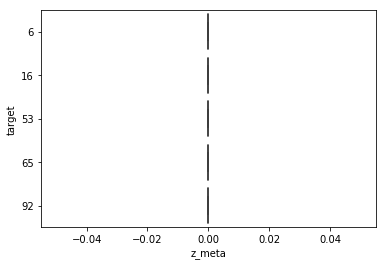

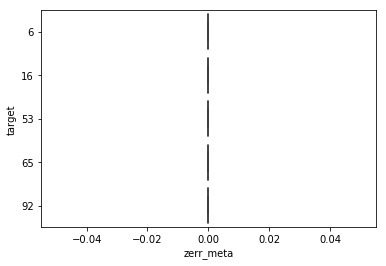

In [451]:
for x in gal.columns:
    sns.boxplot(x=x, y='target', data=gal, orient='h')
    plt.show()

In [452]:
#I picked these by eyeballing the above charts for arbitrarily significant differences between classes. 
#I'll use PCA to combine instances where the same measurements in different passbands provide similar information.
galatts = gal[['all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y', 'amplitude_u', 'amplitude_Y', 'amplitude_g',
                    'percent_beyond_1_std_r', 'percent_beyond_1_std_i', 'percent_beyond_1_std_z', 'percent_beyond_1_std_Y',
                    'maximum_u', 'maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y','max_slope_g', 'max_slope_r', 'max_slope_z',
                     'max_slope_Y', 'median_i', 'median_z', 'median_Y', 'median_absolute_deviation_g', 'median_absolute_deviation_z',
                    'median_absolute_deviation_Y', 'percent_close_to_median_g', 'percent_close_to_median_Y', 'period_fast_g',
                     'period_fast_r', 'period_fast_i', 'period_fast_z', 'period_fast_Y', 'qso_log_chi2_qsonu_u', 
                    'qso_log_chi2_qsonu_g', 'qso_log_chi2_qsonu_r', 'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_z', 
                    'qso_log_chi2_qsonu_Y', 'freq1_freq_r', 'minimum_g', 'minimum_r', 'minimum_i', 'minimum_z', 'minimum_Y',
                    'skew_g', 'skew_r', 'skew_i', 'skew_z', 'skew_Y', 'std_g', 'std_i', 'std_z', 'std_Y']]
galatts.head()

,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,amplitude_u,amplitude_Y,amplitude_g,percent_beyond_1_std_r,percent_beyond_1_std_i,percent_beyond_1_std_z,percent_beyond_1_std_Y,maximum_u,...,minimum_Y,skew_g,skew_r,skew_i,skew_z,skew_Y,std_g,std_i,std_z,std_Y
0,3.0,4.0,121.048015,400.501617,880.533203,0.568966,0.551724,0.517241,0.596491,125.182808,...,-422.815094,0.404755,0.331063,0.285492,0.194883,0.121948,596.576924,332.520885,289.276965,292.182295
5,7.0,7.0,37.748134,15.231738,5.337230,0.326923,0.423077,0.215686,0.352941,71.678154,...,-12.695161,1.980310,0.017738,-0.042035,0.240085,0.519950,1.678401,1.605822,3.563588,5.538789
9,5.0,5.0,7.112926,34.185699,3.576050,0.044444,0.400000,0.400000,0.377778,7.164557,...,-52.764721,-0.042038,4.202053,-0.457403,-0.147721,-1.439236,1.537419,2.520093,4.068033,12.243557
14,3.0,4.0,52.562683,228.430742,26.946058,0.034483,0.034483,0.017241,0.017544,98.330528,...,-24.442568,4.732014,6.687818,6.510663,7.410255,6.699774,6.149013,19.455325,246.982624,58.563573
15,3.0,3.0,8.887536,46.442033,92.284029,0.107143,0.107143,0.125000,0.125000,9.575159,...,-63.193478,-3.296874,-3.513109,-3.271743,-3.171328,-2.124661,22.862074,30.551600,21.272436,12.168863


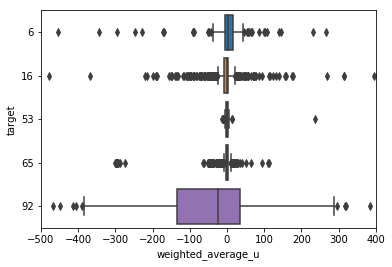

In [453]:
#Quick chart used to redo charts above if the scale needs further examination
sns.boxplot(x='weighted_average_u', y='target', data=gal, orient='h')
plt.xlim(-500,400)
plt.show()

# Examine cases where I kept the same feature for multiple passbands. if there correllations are high enough, use PCA to combine their information.

In [454]:
galfeats = pd.DataFrame(index=galatts.index)

In [455]:
numpeaks = galatts[['all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y']]
numpeaks.corr()
#Combine these

,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y
all_times_nhist_numpeaks_z,1.000000,0.830841
all_times_nhist_numpeaks_Y,0.830841,1.000000


In [456]:
X = StandardScaler().fit_transform(numpeaks)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.08457959 0.91542041]


In [457]:
#91% explained by the best component
P = eig_vec_cov[:, 1]
Y = P.T.dot(Xt)

galatts = galatts.drop(['all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y'],axis=1)

galfeats['numpeaks'] = Y

galfeats.head()

,numpeaks
0,2.561540
5,1.597699
9,2.146007
14,2.561540
15,2.694315


--------

In [458]:
####################################
amp = galatts[['amplitude_u', 'amplitude_Y', 'amplitude_g']]
amp.corr()
#combine Y and G, leave u on its own

,amplitude_u,amplitude_Y,amplitude_g
amplitude_u,1.000000,0.016581,0.244377
amplitude_Y,0.016581,1.000000,0.698281
amplitude_g,0.244377,0.698281,1.000000


In [459]:
amp = amp[['amplitude_Y', 'amplitude_g']]
X = StandardScaler().fit_transform(amp)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.84914063 0.15085937]


In [460]:
#84% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
galfeats['amplitude_u'] = StandardScaler().fit_transform(pd.DataFrame(galatts['amplitude_u']))
galatts = galatts.drop(['amplitude_Y', 'amplitude_g', 'amplitude_u'],axis=1)
galfeats['amp_g_Y'] = Y


galfeats.describe()

,numpeaks,amplitude_u,amp_g_Y
count,2.325000e+03,2.325000e+03,2.325000e+03
mean,-1.955903e-16,3.056098e-18,-3.514512e-17
std,1.353377e+00,1.000215e+00,1.303462e+00
min,-2.073267e+00,-2.915493e-02,-3.029089e-01
25%,-8.868958e-01,-2.872279e-02,-2.926057e-01
50%,-4.713626e-01,-2.827832e-02,-2.740213e-01
75%,2.011164e-01,-2.603235e-02,-1.707895e-01
max,2.694315e+00,4.787844e+01,5.272260e+01


--------

In [461]:
pctbey = galatts[['percent_beyond_1_std_r', 'percent_beyond_1_std_i', 'percent_beyond_1_std_z', 'percent_beyond_1_std_Y']]
pctbey.corr()
#HMM. not sure what to do here, recheck the charts to see if they indicate similar classes or not

,percent_beyond_1_std_r,percent_beyond_1_std_i,percent_beyond_1_std_z,percent_beyond_1_std_Y
percent_beyond_1_std_r,1.000000,0.613829,0.567841,0.428610
percent_beyond_1_std_i,0.613829,1.000000,0.608781,0.469052
percent_beyond_1_std_z,0.567841,0.608781,1.000000,0.565475
percent_beyond_1_std_Y,0.428610,0.469052,0.565475,1.000000


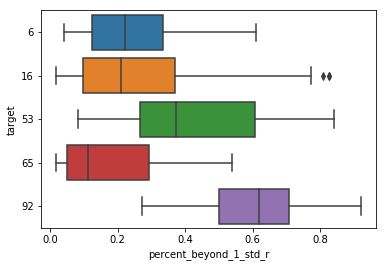

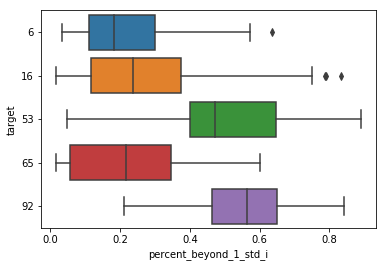

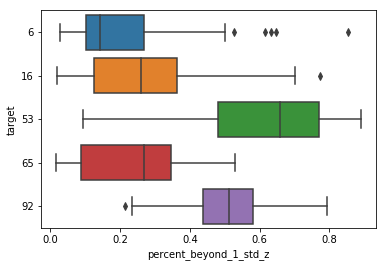

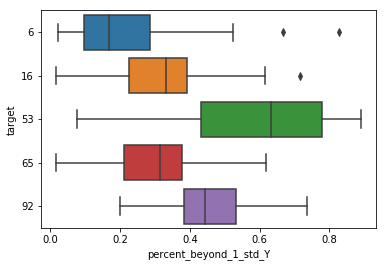

In [462]:
sns.boxplot(x='percent_beyond_1_std_r', y='target', data=gal, orient='h')
#plt.xlim(-500,400)
plt.show()
sns.boxplot(x='percent_beyond_1_std_i', y='target', data=gal, orient='h')
#plt.xlim(-500,400)
plt.show()
sns.boxplot(x='percent_beyond_1_std_z', y='target', data=gal, orient='h')
#plt.xlim(-500,400)
plt.show()
sns.boxplot(x='percent_beyond_1_std_Y', y='target', data=gal, orient='h')
#plt.xlim(-500,400)
plt.show()
#these are not different enough to include separately, trying PCA

In [463]:
X = StandardScaler().fit_transform(pctbey)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.65799322 0.15227763 0.09824592 0.09148323]


In [464]:
#65% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['percent_beyond_1_std_r', 'percent_beyond_1_std_i', 'percent_beyond_1_std_z', 'percent_beyond_1_std_Y'],axis=1)
galfeats['pct_beyond_1_std'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std
0,2.561540,-0.025954,-0.018744,-3.326859
5,1.597699,-0.028182,-0.301992,-0.604081
9,2.146007,-0.029002,-0.300665,-0.476931
14,2.561540,-0.027786,-0.275415,2.961350
15,2.694315,-0.028954,-0.274532,1.881650


--------

In [465]:
maxes = galatts[['maximum_u', 'maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y',]]
maxes.corr()


,maximum_u,maximum_g,maximum_r,maximum_z,maximum_Y
maximum_u,1.000000,0.108219,0.022907,0.015521,0.014344
maximum_g,0.108219,1.000000,0.901523,0.840666,0.827065
maximum_r,0.022907,0.901523,1.000000,0.921374,0.907448
maximum_z,0.015521,0.840666,0.921374,1.000000,0.984343
maximum_Y,0.014344,0.827065,0.907448,0.984343,1.000000


In [466]:
#Leave u as is, combine g, r, z, and Y
galfeats['maximum_u'] = StandardScaler().fit_transform(pd.DataFrame(galatts['maximum_u']))

maxes = galatts[['maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y',]]

In [467]:
X = StandardScaler().fit_transform(maxes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.92316213 0.05510262 0.01799952 0.00373574]


In [468]:
#92% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['maximum_u','maximum_g', 'maximum_r', 'maximum_z', 'maximum_Y'],axis=1)
galfeats['max_grzY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284


--------

In [469]:
maxslopes = galatts[['max_slope_g', 'max_slope_r', 'max_slope_z', 'max_slope_Y']]
maxslopes.corr()

,max_slope_g,max_slope_r,max_slope_z,max_slope_Y
max_slope_g,1.000000,0.225856,0.079565,0.231664
max_slope_r,0.225856,1.000000,0.144459,0.511827
max_slope_z,0.079565,0.144459,1.000000,0.381884
max_slope_Y,0.231664,0.511827,0.381884,1.000000


In [470]:
maxslopes = galatts[['max_slope_g', 'max_slope_r', 'max_slope_z', 'max_slope_Y']]
X = StandardScaler().fit_transform(maxslopes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.45940547 0.23688366 0.19753158 0.10617928]


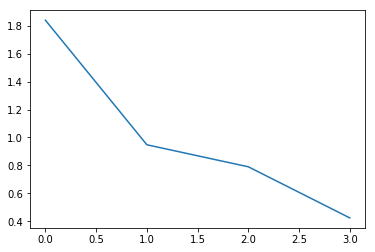

array([1.8384126 , 0.94794237, 0.79046631, 0.42489988])

In [471]:
plt.plot(eig_val_cov)
plt.show()
eig_val_cov

In [472]:
#This is tough, but the 2nd component is just falling under most rules-of-thumb, so I'll just keep the 1.
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['max_slope_g', 'max_slope_r', 'max_slope_z', 'max_slope_Y'],axis=1)
galfeats['maxslope_grzY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521


--------

In [473]:
medians = galatts[['median_i', 'median_z', 'median_Y']]
medians.corr()

,median_i,median_z,median_Y
median_i,1.000000,0.946934,0.914704
median_z,0.946934,1.000000,0.981835
median_Y,0.914704,0.981835,1.000000


In [474]:

X = StandardScaler().fit_transform(medians)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.96530453 0.03026699 0.00442848]


In [475]:
#Love the easy ones
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['median_i', 'median_z', 'median_Y'],axis=1)
galfeats['median_izY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366


---------------------

In [476]:
medabsdev = galatts[['median_absolute_deviation_g', 'median_absolute_deviation_z','median_absolute_deviation_Y']]
medabsdev.corr()

,median_absolute_deviation_g,median_absolute_deviation_z,median_absolute_deviation_Y
median_absolute_deviation_g,1.000000,0.479141,0.370368
median_absolute_deviation_z,0.479141,1.000000,0.955264
median_absolute_deviation_Y,0.370368,0.955264,1.000000


In [477]:
X = StandardScaler().fit_transform(medabsdev)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.74852682 0.2391063  0.01236688]


In [478]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['median_absolute_deviation_g', 'median_absolute_deviation_z','median_absolute_deviation_Y'],axis=1)
galfeats['medabsdev_gzY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148


---------------------

In [479]:
medianpct = galatts[['percent_close_to_median_g', 'percent_close_to_median_Y']]
medianpct.corr()

,percent_close_to_median_g,percent_close_to_median_Y
percent_close_to_median_g,1.000000,0.396607
percent_close_to_median_Y,0.396607,1.000000


In [480]:
X = StandardScaler().fit_transform(medianpct)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.69830351 0.30169649]


In [481]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['percent_close_to_median_g', 'percent_close_to_median_Y'],axis=1)
galfeats['medianpct_gY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810,-2.152931
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547,-0.172638
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861,-0.266269
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801,2.417288
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148,1.488768


---------------------

In [482]:
periodfast = galatts[['period_fast_g', 'period_fast_r', 'period_fast_i', 'period_fast_z','period_fast_Y']]
periodfast.corr()

,period_fast_g,period_fast_r,period_fast_i,period_fast_z,period_fast_Y
period_fast_g,1.000000,0.216988,0.211915,0.212705,0.135500
period_fast_r,0.216988,1.000000,0.249918,0.264485,0.204959
period_fast_i,0.211915,0.249918,1.000000,0.257919,0.205105
period_fast_z,0.212705,0.264485,0.257919,1.000000,0.266017
period_fast_Y,0.135500,0.204959,0.205105,0.266017,1.000000


In [483]:
X = StandardScaler().fit_transform(periodfast)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.37925142 0.17474024 0.14194606 0.15405665 0.15000563]


array([1.89707304, 0.87407716, 0.71003571, 0.77061468, 0.75035088])

In [484]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['period_fast_g', 'period_fast_r', 'period_fast_i', 'period_fast_z','period_fast_Y'],axis=1)
galfeats['periodfast_grizY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810,-2.152931,-0.556172
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547,-0.172638,0.200382
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861,-0.266269,1.602353
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801,2.417288,-0.409250
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148,1.488768,1.862700


---------------

In [485]:
qlcq = galatts[['qso_log_chi2_qsonu_u', 'qso_log_chi2_qsonu_g','qso_log_chi2_qsonu_r', 
                'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_z','qso_log_chi2_qsonu_Y']]
qlcq.corr()

,qso_log_chi2_qsonu_u,qso_log_chi2_qsonu_g,qso_log_chi2_qsonu_r,qso_log_chi2_qsonu_i,qso_log_chi2_qsonu_z,qso_log_chi2_qsonu_Y
qso_log_chi2_qsonu_u,1.000000,0.543143,0.526718,0.545944,0.579092,0.614285
qso_log_chi2_qsonu_g,0.543143,1.000000,0.719296,0.715356,0.694336,0.647595
qso_log_chi2_qsonu_r,0.526718,0.719296,1.000000,0.725100,0.724146,0.672913
qso_log_chi2_qsonu_i,0.545944,0.715356,0.725100,1.000000,0.814105,0.763764
qso_log_chi2_qsonu_z,0.579092,0.694336,0.724146,0.814105,1.000000,0.847952
qso_log_chi2_qsonu_Y,0.614285,0.647595,0.672913,0.763764,0.847952,1.000000


In [486]:
X = StandardScaler().fit_transform(qlcq)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.73302163 0.09151098 0.06972867 0.02331486 0.03614576 0.0462781 ]


array([4.40002229, 0.54930212, 0.41855203, 0.13994934, 0.21696787,
       0.2777881 ])

In [487]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

galatts = galatts.drop(['qso_log_chi2_qsonu_u', 'qso_log_chi2_qsonu_g','qso_log_chi2_qsonu_r', 
                'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_z','qso_log_chi2_qsonu_Y'],axis=1)
galfeats['qlcq_ugrizY'] = Y

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810,-2.152931,-0.556172,-5.361279
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547,-0.172638,0.200382,1.921143
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861,-0.266269,1.602353,1.938777
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801,2.417288,-0.409250,-0.687691
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148,1.488768,1.862700,-0.578715


---------------

In [488]:
galfeats['freq1_freq_r'] = StandardScaler().fit_transform(pd.DataFrame(galatts['freq1_freq_r']))
galatts = galatts.drop(['freq1_freq_r'], axis=1)
galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810,-2.152931,-0.556172,-5.361279,-1.147065
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547,-0.172638,0.200382,1.921143,1.190369
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861,-0.266269,1.602353,1.938777,0.200244
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801,2.417288,-0.409250,-0.687691,0.026394
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148,1.488768,1.862700,-0.578715,-1.277635


---------------

In [489]:
mins = galatts[['minimum_g', 'minimum_r', 'minimum_i', 'minimum_z', 'minimum_Y']]
mins.corr()

,minimum_g,minimum_r,minimum_i,minimum_z,minimum_Y
minimum_g,1.000000,0.743568,0.536652,0.323012,0.214367
minimum_r,0.743568,1.000000,0.694316,0.463956,0.321478
minimum_i,0.536652,0.694316,1.000000,0.888150,0.795714
minimum_z,0.323012,0.463956,0.888150,1.000000,0.972351
minimum_Y,0.214367,0.321478,0.795714,0.972351,1.000000


In [490]:
X = StandardScaler().fit_transform(mins)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.68666581 0.24136917 0.05125619 0.00220201 0.01850682]


array([3.43480637, 1.20736516, 0.25639121, 0.01101478, 0.09257393])

In [491]:
#I'll keep 2, in this case
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
galfeats['min_grizY_1'] = Y

P = eig_vec_cov[:, 1]
Y = P.T.dot(Xt)
galfeats['min_grizY_2'] = Y


galatts = galatts.drop(['minimum_g', 'minimum_r', 'minimum_i', 'minimum_z', 'minimum_Y'],axis=1)


galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r,min_grizY_1,min_grizY_2
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810,-2.152931,-0.556172,-5.361279,-1.147065,-0.000077,-0.237530
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547,-0.172638,0.200382,1.921143,1.190369,0.669655,0.272465
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861,-0.266269,1.602353,1.938777,0.200244,0.664028,0.277108
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801,2.417288,-0.409250,-0.687691,0.026394,0.664057,0.269636
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148,1.488768,1.862700,-0.578715,-1.277635,0.509122,0.180973


---------------

In [492]:
skews = galatts[['skew_g', 'skew_r', 'skew_i', 'skew_z', 'skew_Y']]
skews.corr()

,skew_g,skew_r,skew_i,skew_z,skew_Y
skew_g,1.000000,0.758817,0.737583,0.649377,0.523816
skew_r,0.758817,1.000000,0.722719,0.659652,0.533633
skew_i,0.737583,0.722719,1.000000,0.697127,0.561405
skew_z,0.649377,0.659652,0.697127,1.000000,0.601703
skew_Y,0.523816,0.533633,0.561405,0.601703,1.000000


In [493]:
X = StandardScaler().fit_transform(skews)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.71785365 0.11148924 0.06936172 0.04731173 0.05398366]


array([3.59081271, 0.55768608, 0.34695782, 0.23666044, 0.27003443])

In [494]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
galfeats['skew_grizY'] = Y

galatts = galatts.drop(['skew_g', 'skew_r', 'skew_i', 'skew_z', 'skew_Y'],axis=1)


galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r,min_grizY_1,min_grizY_2,skew_grizY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810,-2.152931,-0.556172,-5.361279,-1.147065,-0.000077,-0.237530,0.203166
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547,-0.172638,0.200382,1.921143,1.190369,0.669655,0.272465,-0.077104
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861,-0.266269,1.602353,1.938777,0.200244,0.664028,0.277108,0.148806
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801,2.417288,-0.409250,-0.687691,0.026394,0.664057,0.269636,-5.463728
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148,1.488768,1.862700,-0.578715,-1.277635,0.509122,0.180973,3.284595


---------------

In [495]:
stds = galatts[['std_g', 'std_i', 'std_z', 'std_Y']]
stds.corr()

,std_g,std_i,std_z,std_Y
std_g,1.000000,0.849716,0.800666,0.774549
std_i,0.849716,1.000000,0.973620,0.967305
std_z,0.800666,0.973620,1.000000,0.989278
std_Y,0.774549,0.967305,0.989278,1.000000


In [496]:
X = StandardScaler().fit_transform(stds)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.92097706 0.07010855 0.00647151 0.00244288]


array([3.68549338, 0.28055488, 0.02589717, 0.00977574])

In [497]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
galfeats['std_gizY'] = Y

del galatts

galfeats.head()

,numpeaks,amplitude_u,amp_g_Y,pct_beyond_1_std,maximum_u,max_grzY,maxslope_grzY,median_izY,medabsdev_gzY,medianpct_gY,periodfast_grizY,qlcq_ugrizY,freq1_freq_r,min_grizY_1,min_grizY_2,skew_grizY,std_gizY
0,2.561540,-0.025954,-0.018744,-3.326859,-0.025405,0.121370,-0.201711,-0.046161,0.202810,-2.152931,-0.556172,-5.361279,-1.147065,-0.000077,-0.237530,0.203166,-0.052565
5,1.597699,-0.028182,-0.301992,-0.604081,-0.026462,0.257265,-0.463304,0.051141,-0.375547,-0.172638,0.200382,1.921143,1.190369,0.669655,0.272465,-0.077104,-0.311764
9,2.146007,-0.029002,-0.300665,-0.476931,-0.027737,0.256494,-0.459441,0.051227,-0.372861,-0.266269,1.602353,1.938777,0.200244,0.664028,0.277108,0.148806,-0.310930
14,2.561540,-0.027786,-0.275415,2.961350,-0.025936,0.156418,-0.447079,0.050830,-0.370801,2.417288,-0.409250,-0.687691,0.026394,0.664057,0.269636,-5.463728,-0.270250
15,2.694315,-0.028954,-0.274532,1.881650,-0.027689,0.247284,-0.437521,0.050366,-0.370148,1.488768,1.862700,-0.578715,-1.277635,0.509122,0.180973,3.284595,-0.299659


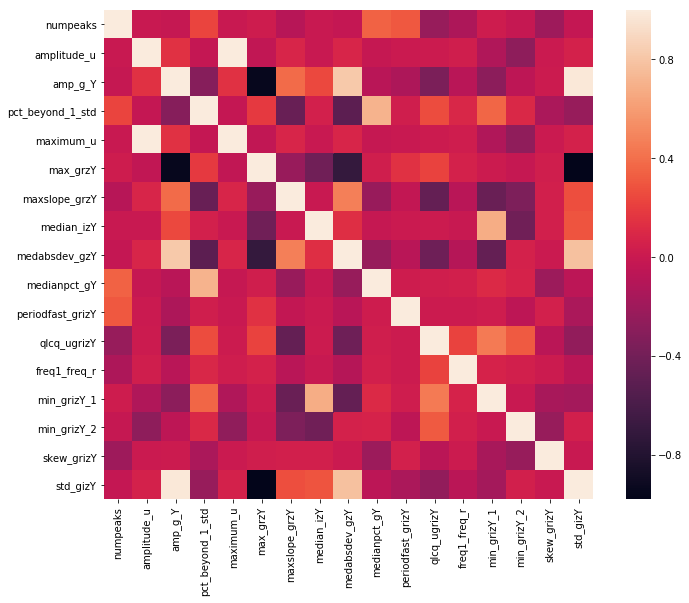

In [498]:
cor = galfeats.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, square=True)
plt.show()

In [499]:
#Based on the above, there may still be some reduction needed on the galactic side, but let's try out the KNN model again first:

In [500]:
#Split X,Y
galX = galfeats
galY = gal['target']


#Create Train/Test splits
galX_train, galX_test, galY_train, galY_test = train_test_split(
    galX, galY, test_size=0.5)

#First, galactic objects
galknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
galknn.fit(galX_train, galY_train)

galknn.score(galX_test, galY_test)

0.937231298366294

In [501]:
#MUCH BETTER :)

# Extra-galactic Feature Selection

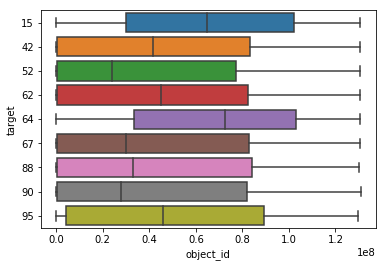

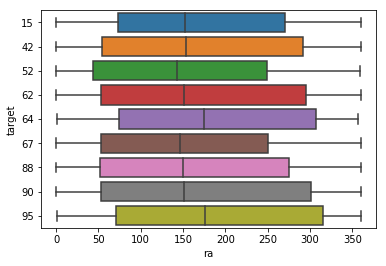

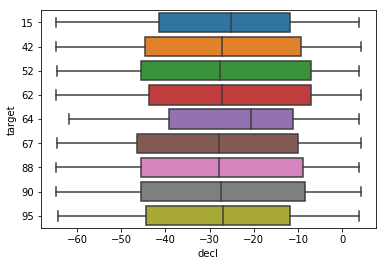

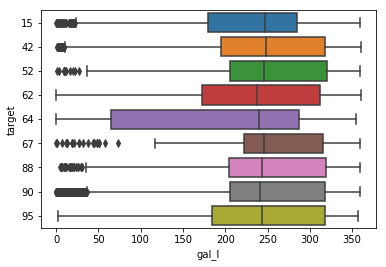

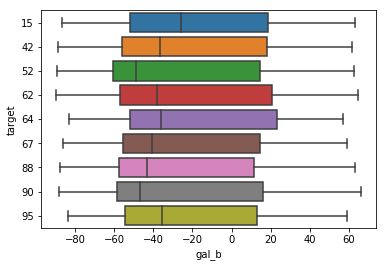

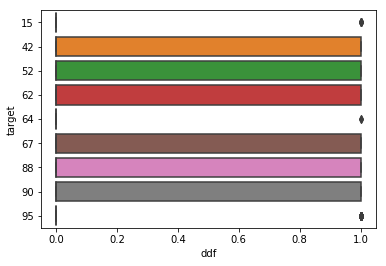

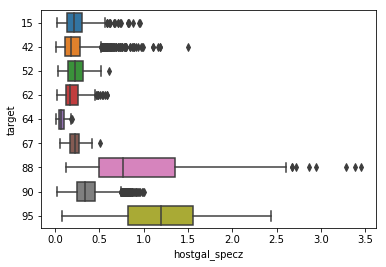

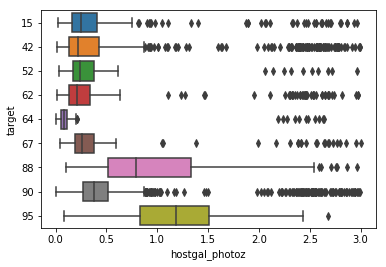

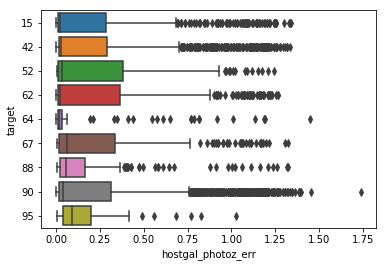

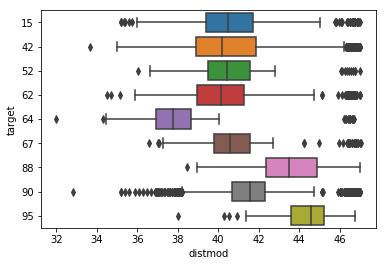

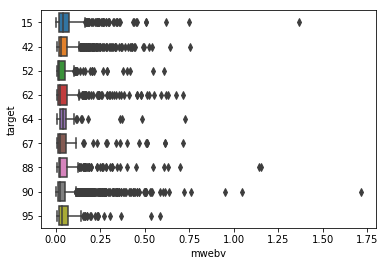

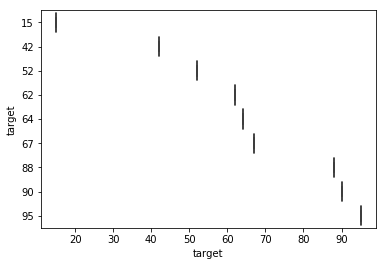

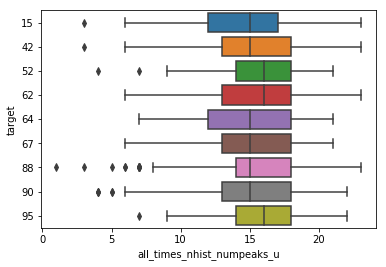

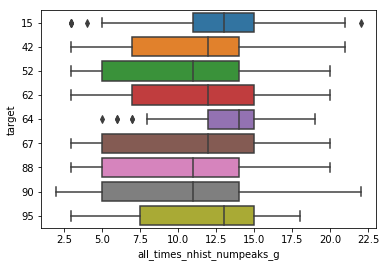

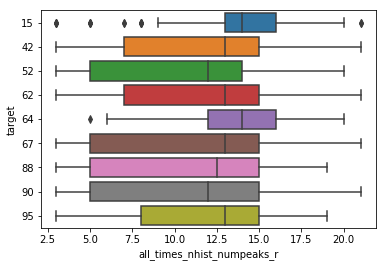

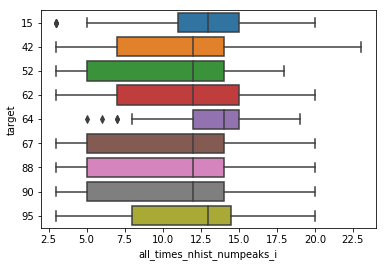

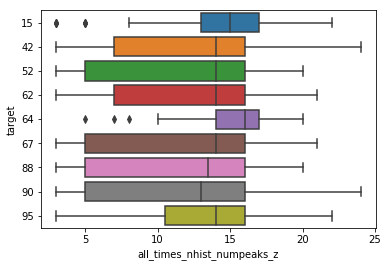

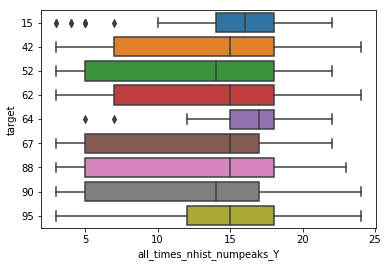

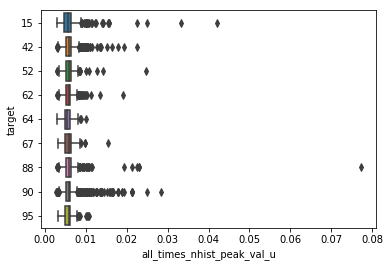

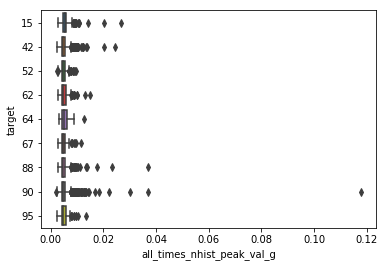

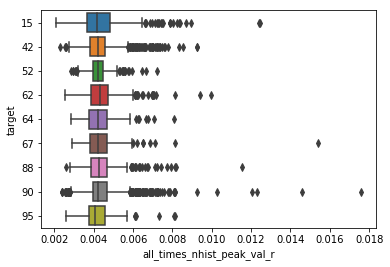

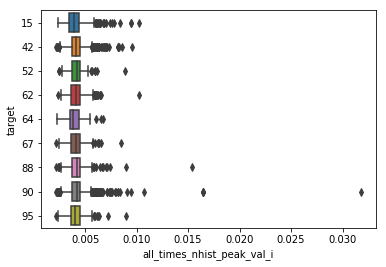

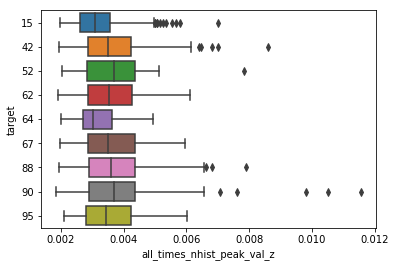

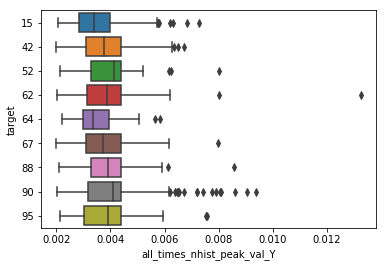

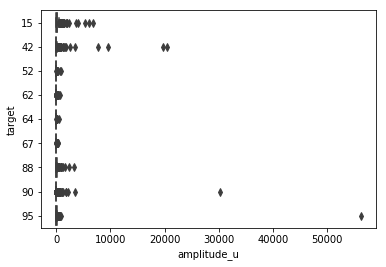

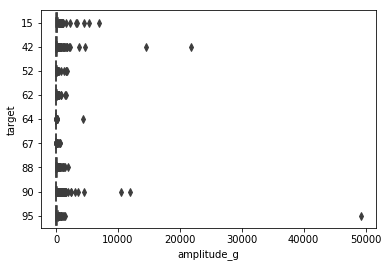

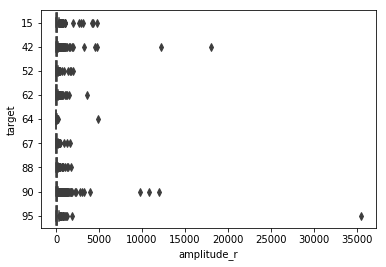

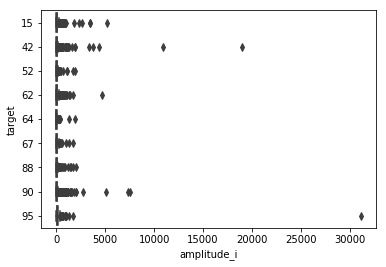

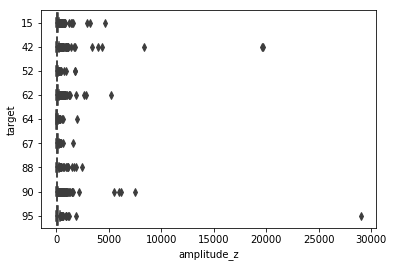

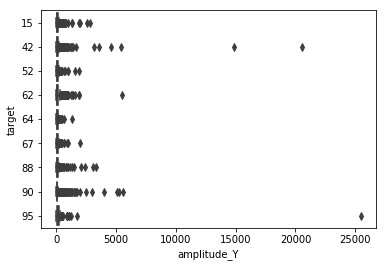

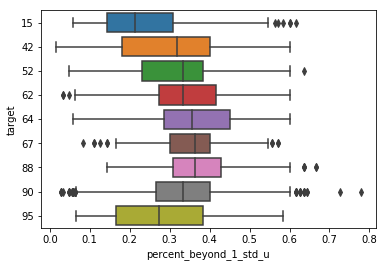

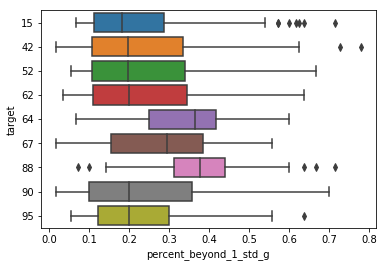

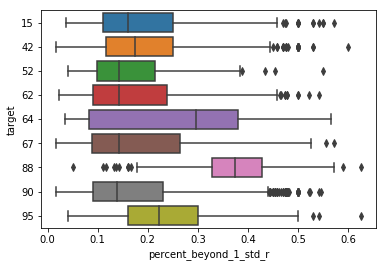

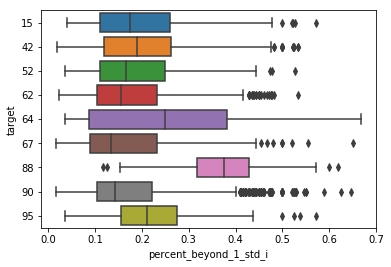

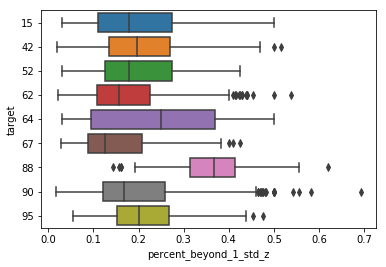

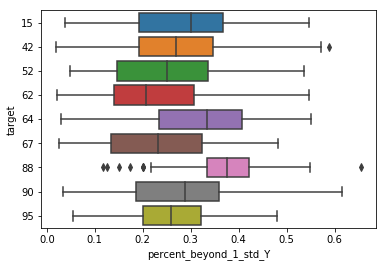

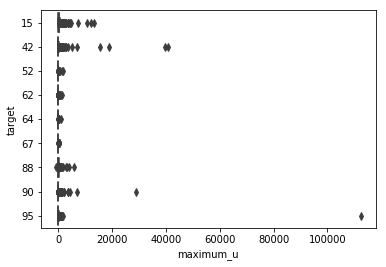

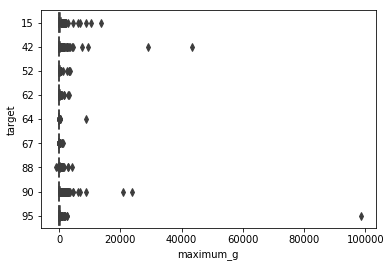

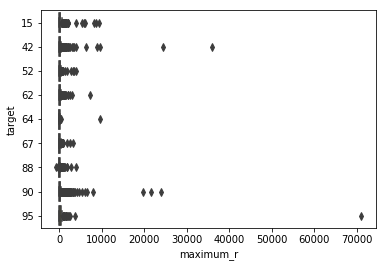

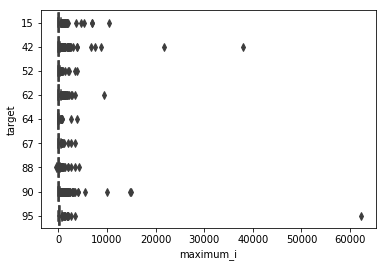

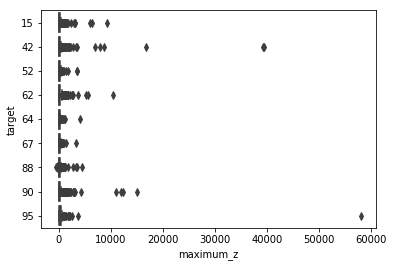

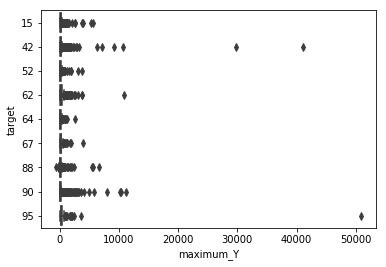

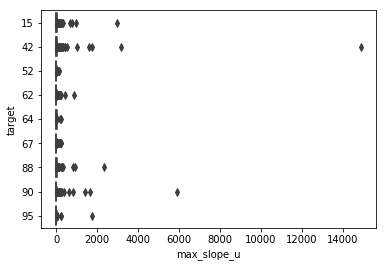

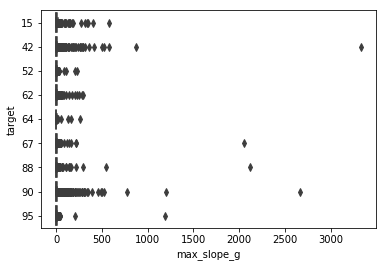

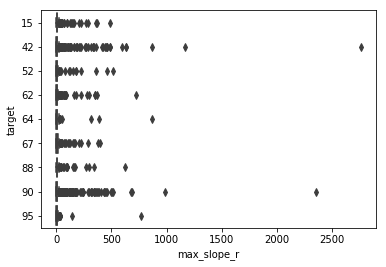

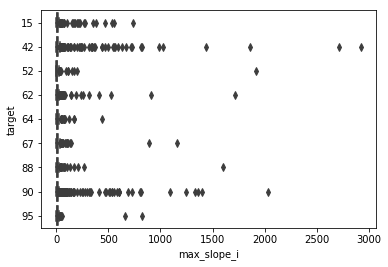

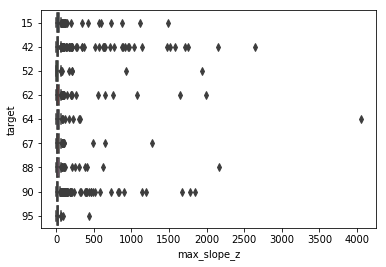

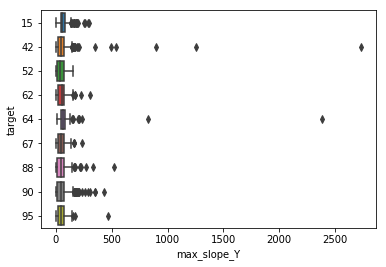

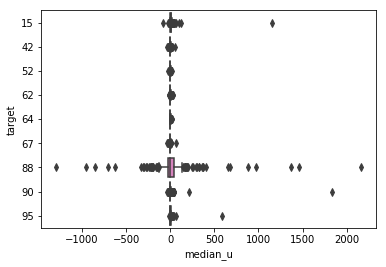

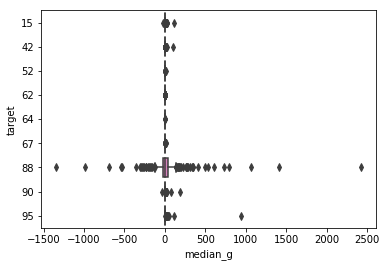

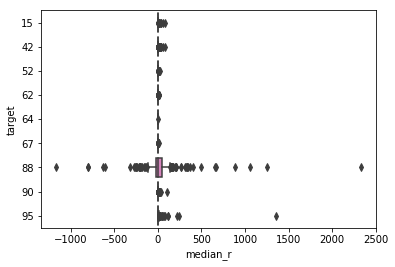

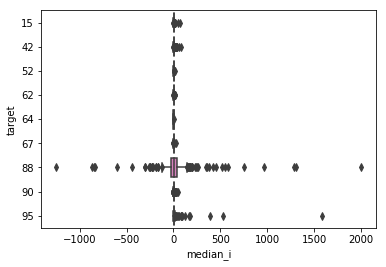

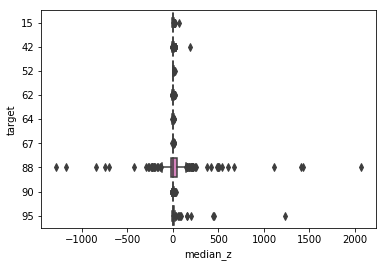

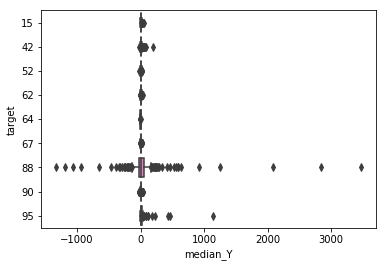

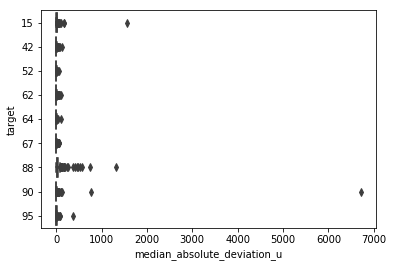

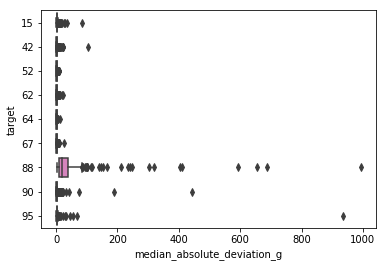

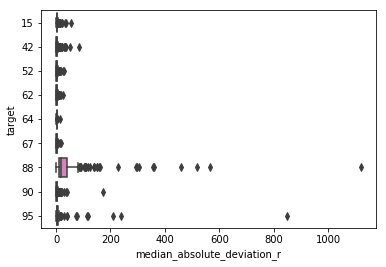

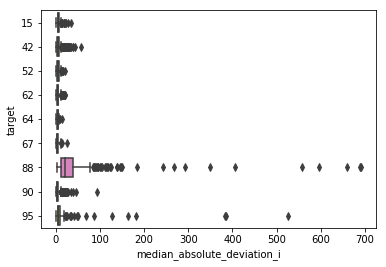

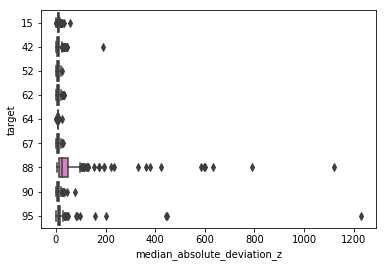

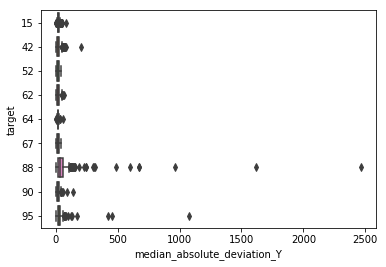

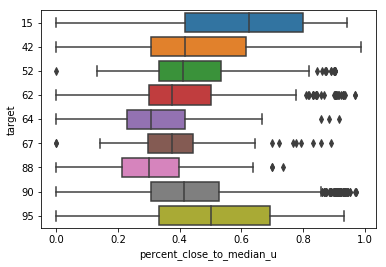

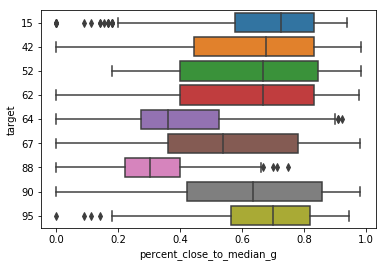

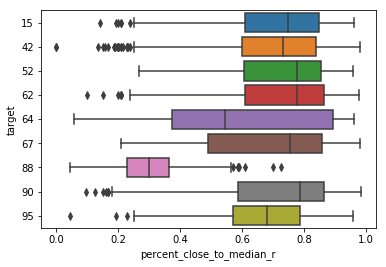

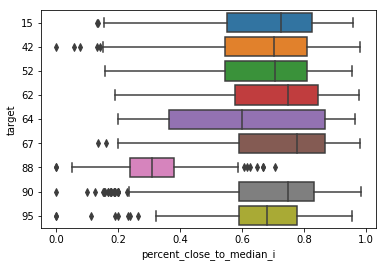

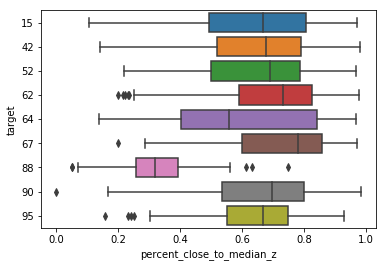

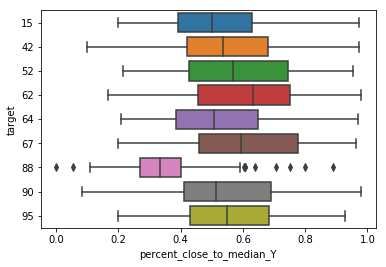

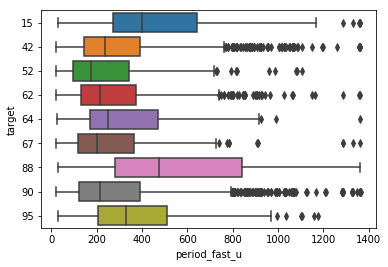

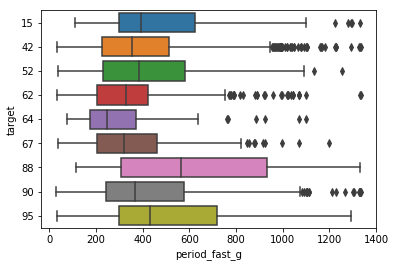

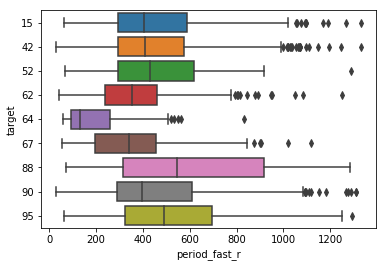

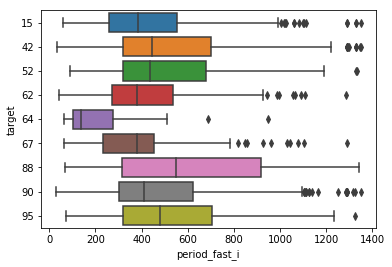

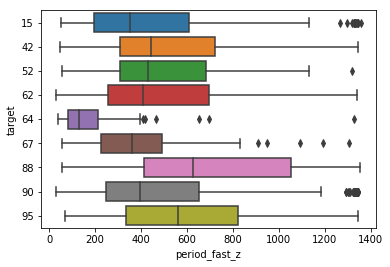

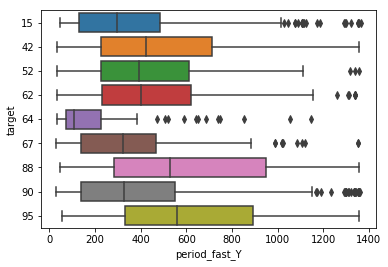

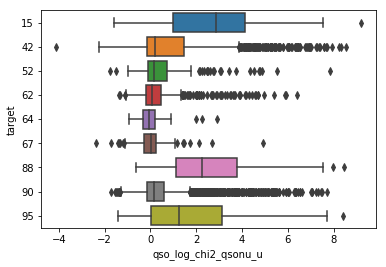

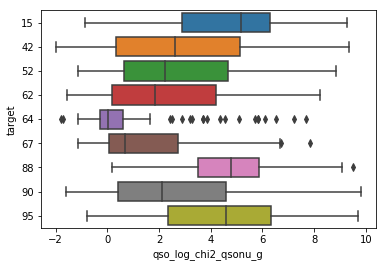

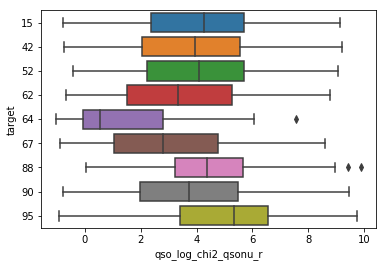

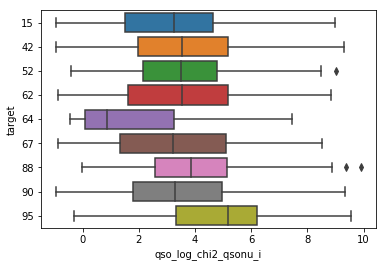

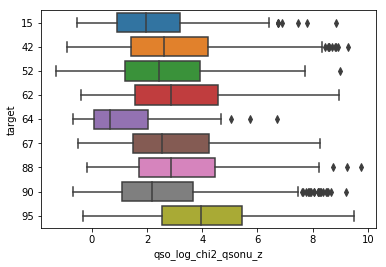

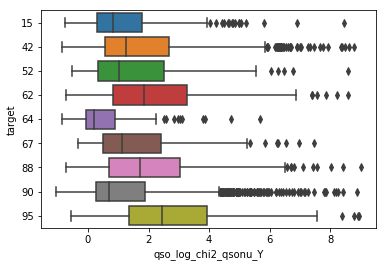

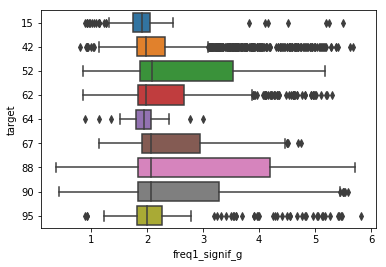

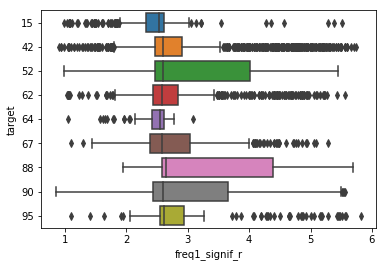

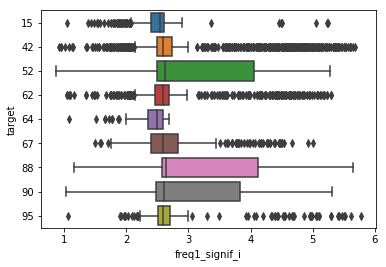

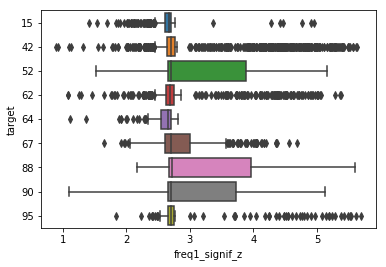

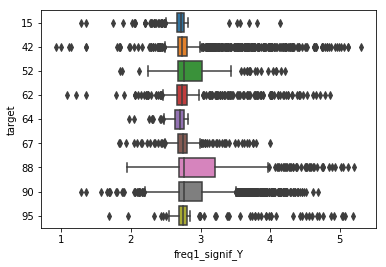

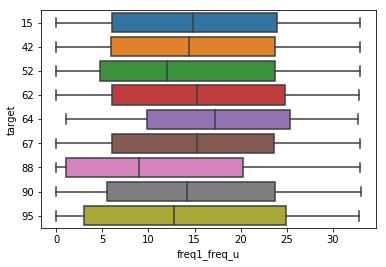

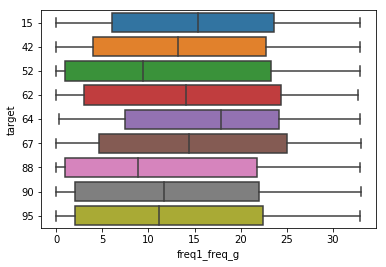

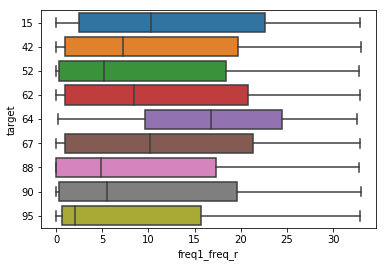

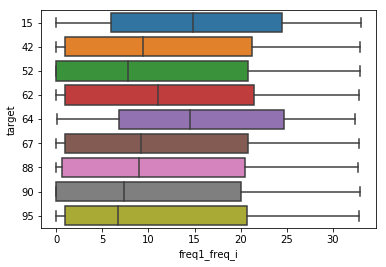

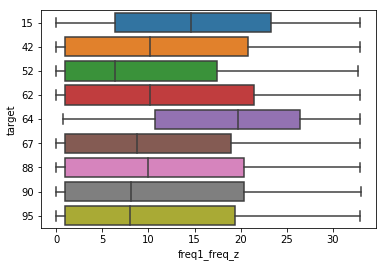

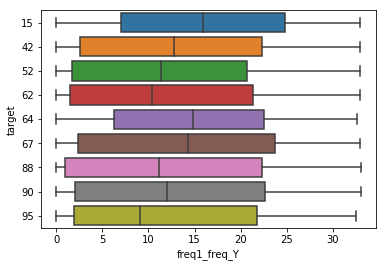

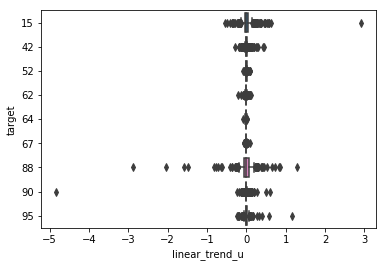

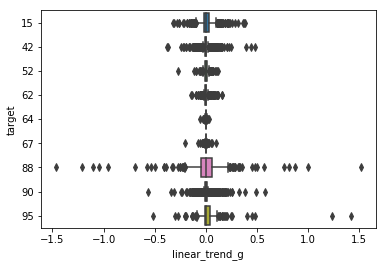

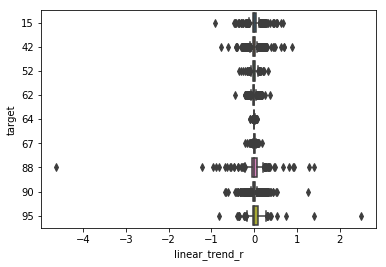

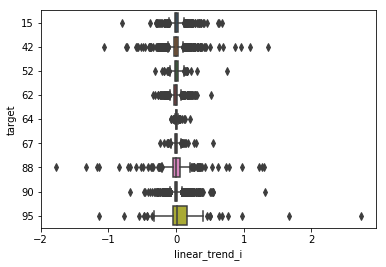

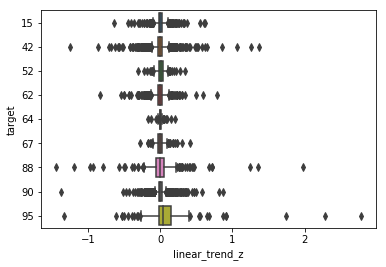

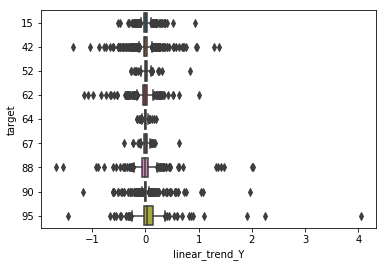

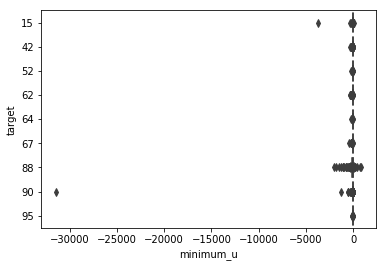

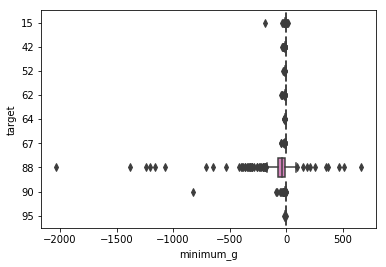

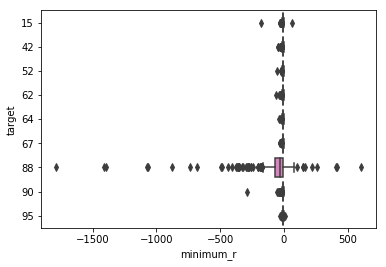

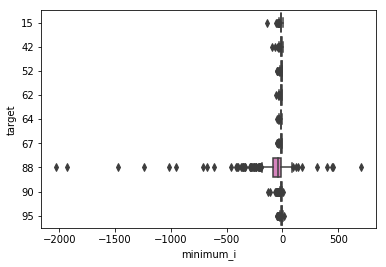

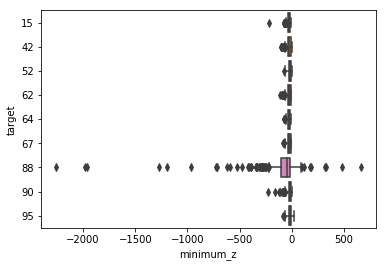

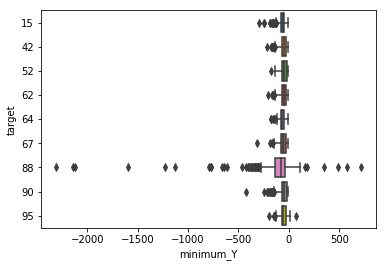

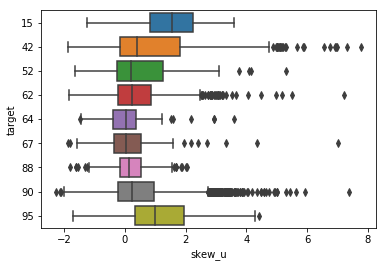

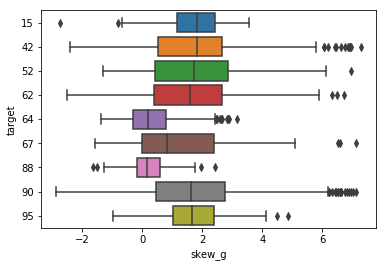

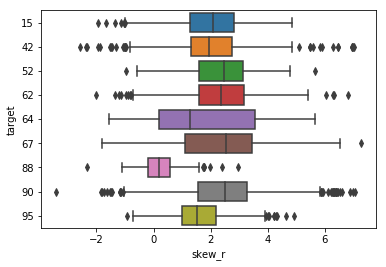

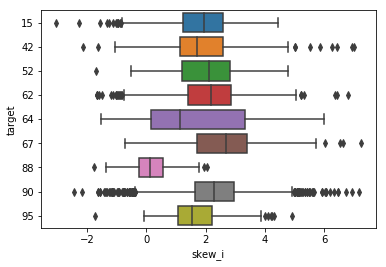

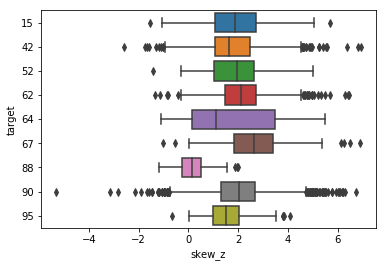

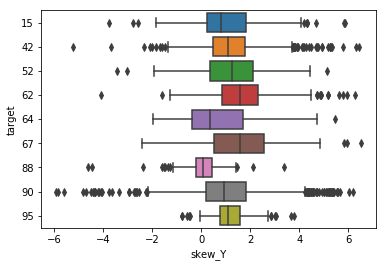

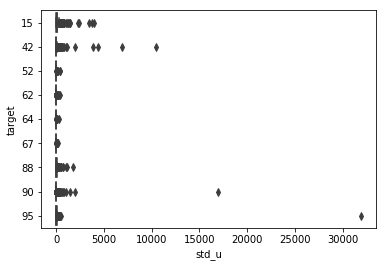

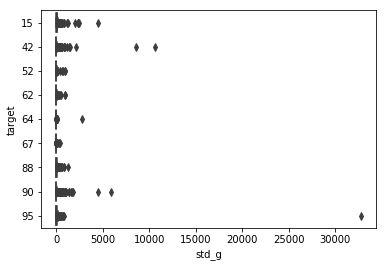

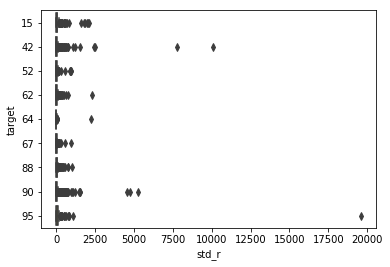

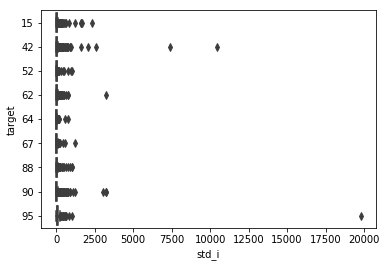

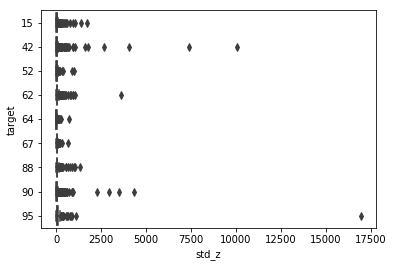

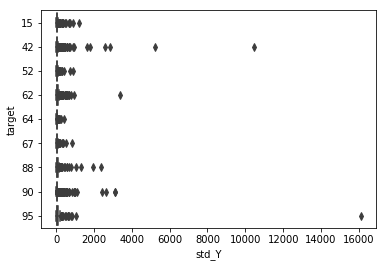

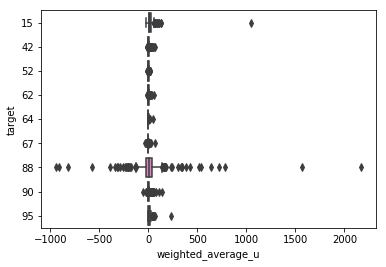

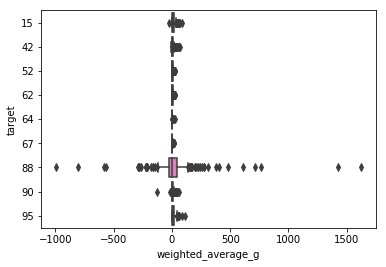

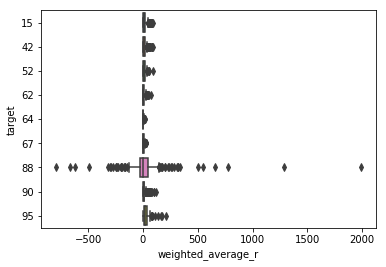

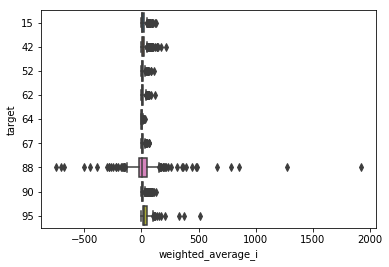

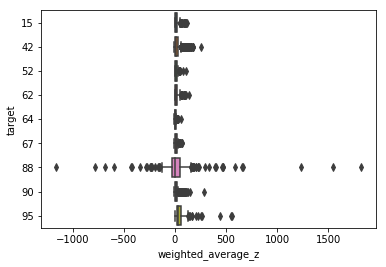

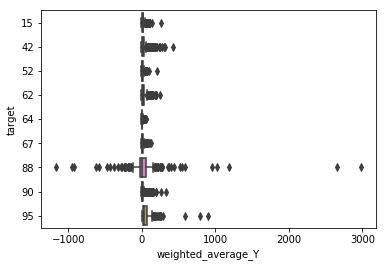

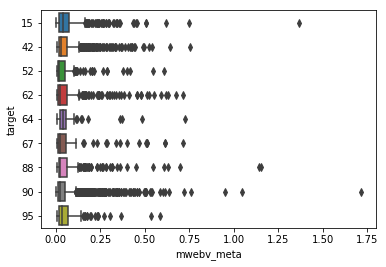

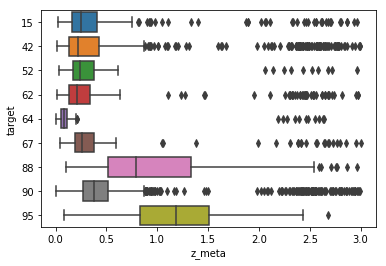

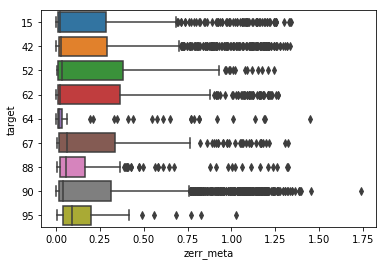

In [502]:
for x in extragal.columns:
    sns.boxplot(x=x, y='target', data=extragal, orient='h')
    plt.show()

In [503]:
#I picked these by eyeballing the above charts for arbitrarily significant differences between classes. 
#I'll use PCA to combine instances where the same measurements in different passbands provide similar information.
egalatts = extragal[['hostgal_specz', 'hostgal_photoz', 'distmod', 'all_times_nhist_numpeaks_g', 'all_times_nhist_numpeaks_r',
                     'all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y', 'amplitude_u', 'amplitude_g', 
                     'percent_beyond_1_std_u', 'percent_beyond_1_std_g', 'percent_beyond_1_std_r', 'percent_beyond_1_std_i',
                     'percent_beyond_1_std_z', 'percent_beyond_1_std_Y', 'maximum_u', 'maximum_g', 'maximum_i', 'maximum_z',
                     'maximum_Y', 'max_slope_z', 'max_slope_Y', 'max_slope_g', 'median_u', 'median_i', 'median_z', 'median_Y', 
                     'median_absolute_deviation_g', 'median_absolute_deviation_z', 'median_absolute_deviation_Y',
                     'percent_close_to_median_u', 'percent_close_to_median_g', 'period_fast_r', 'period_fast_i', 
                     'period_fast_z', 'qso_log_chi2_qsonu_u', 'qso_log_chi2_qsonu_g', 'qso_log_chi2_qsonu_r', 
                     'qso_log_chi2_qsonu_i', 'qso_log_chi2_qsonu_Y', 'freq1_signif_g', 'freq1_signif_r', 'freq1_signif_i',
                     'freq1_signif_z', 'freq1_signif_Y', 'freq1_freq_u', 'freq1_freq_r', 'freq1_freq_g', 'linear_trend_u',
                     'linear_trend_g', 'linear_trend_r', 'linear_trend_i', 'linear_trend_z', 'minimum_z', 'skew_g', 'skew_r',
                     'skew_z', 'std_u', 'std_r', 'std_i', 'std_z', 'std_Y']]
#extragal.
egalatts.head()

,hostgal_specz,hostgal_photoz,distmod,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y,amplitude_u,amplitude_g,percent_beyond_1_std_u,...,linear_trend_z,minimum_z,skew_g,skew_r,skew_z,std_u,std_r,std_i,std_z,std_Y
1,1.8181,1.6267,45.4063,3.0,3.0,3.0,3.0,14.622504,10.422385,0.385714,...,-0.017949,-12.286801,-0.085494,-0.022066,-0.062403,7.062516,5.718981,6.392561,6.349526,7.030448
2,0.2320,0.2262,40.2561,7.0,7.0,7.0,7.0,4.701063,4.543094,0.333333,...,0.009337,-5.836310,0.457635,2.315707,2.462542,1.816127,5.505767,8.112835,10.604821,13.201397
3,0.3037,0.2813,40.7951,4.0,4.0,4.0,4.0,10.944189,97.931352,0.180556,...,-0.021154,-15.494463,6.817994,5.534683,3.382600,4.343961,31.671373,34.654080,32.772464,25.822133
4,0.1934,0.2415,40.4166,3.0,3.0,3.0,4.0,6.067815,19.896143,0.333333,...,0.020095,-16.543753,2.315295,2.995322,3.802308,2.341279,21.135263,26.043193,26.633303,21.245772
6,0.1352,0.1820,39.7279,3.0,3.0,3.0,4.0,141.604316,726.110041,0.095238,...,0.025086,-5.226799,5.159199,5.179738,5.113631,51.918012,215.250206,173.640682,129.250487,113.293962


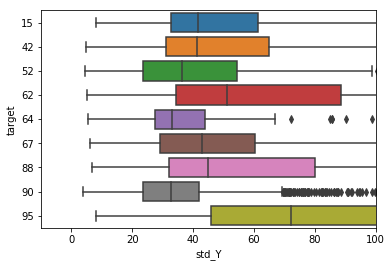

In [504]:
#Quick chart used to redo charts above if the scale needs further examination
sns.boxplot(x='std_Y', y='target', data=extragal, orient='h')
plt.xlim(-10,100)
plt.show()

# Examine cases where I kept the same feature for multiple passbands. if there correllations are high enough, use PCA to combine their information.

In [505]:
egalfeats = pd.DataFrame(index=egalatts.index)

In [506]:
enumpeaks = egalatts[['all_times_nhist_numpeaks_g', 'all_times_nhist_numpeaks_r',
       'all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y']]
enumpeaks.corr()
#Combine these

,all_times_nhist_numpeaks_g,all_times_nhist_numpeaks_r,all_times_nhist_numpeaks_z,all_times_nhist_numpeaks_Y
all_times_nhist_numpeaks_g,1.000000,0.815008,0.813244,0.816948
all_times_nhist_numpeaks_r,0.815008,1.000000,0.840279,0.842611
all_times_nhist_numpeaks_z,0.813244,0.840279,1.000000,0.874095
all_times_nhist_numpeaks_Y,0.816948,0.842611,0.874095,1.000000


In [508]:
enumpeaks_scaler = StandardScaler().fit(enumpeaks)
X = enumpeaks_scaler.transform(enumpeaks)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.87536594 0.05122226 0.04195456 0.03145725]


In [509]:
#91% explained by the best component
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop(['all_times_nhist_numpeaks_g', 'all_times_nhist_numpeaks_r',
       'all_times_nhist_numpeaks_z', 'all_times_nhist_numpeaks_Y'],axis=1)

egalfeats['numpeaks_grzY'] = Y

egalfeats.head()

,numpeaks_grzY
1,-3.322505
2,-1.789373
3,-2.939222
4,-3.237392
6,-3.237392


--------

In [510]:
eamplitude = egalatts[['amplitude_u','amplitude_g']]
eamplitude.corr()
#Combine these

,amplitude_u,amplitude_g
amplitude_u,1.000000,0.861434
amplitude_g,0.861434,1.000000


In [511]:
eamplitude_scaler = StandardScaler().fit(eamplitude)
X = eamplitude_scaler.transform(eamplitude)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.06928302 0.93071698]


In [512]:
P = eig_vec_cov[:, 1]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eamplitude.columns],axis=1)

egalfeats['amplitude_ug'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug
1,-3.322505,0.128003
2,-1.789373,0.140245
3,-2.939222,0.055039
4,-3.237392,0.125991
6,-3.237392,-0.582108


--------

In [513]:
epctbey = egalatts[['percent_beyond_1_std_u',
       'percent_beyond_1_std_g', 'percent_beyond_1_std_r',
       'percent_beyond_1_std_i', 'percent_beyond_1_std_z',
       'percent_beyond_1_std_Y']]
epctbey.corr()
#Combine these

,percent_beyond_1_std_u,percent_beyond_1_std_g,percent_beyond_1_std_r,percent_beyond_1_std_i,percent_beyond_1_std_z,percent_beyond_1_std_Y
percent_beyond_1_std_u,1.000000,0.255969,0.136933,0.149318,0.183432,0.265654
percent_beyond_1_std_g,0.255969,1.000000,0.388128,0.333004,0.284424,0.296544
percent_beyond_1_std_r,0.136933,0.388128,1.000000,0.441159,0.337393,0.258952
percent_beyond_1_std_i,0.149318,0.333004,0.441159,1.000000,0.394079,0.305649
percent_beyond_1_std_z,0.183432,0.284424,0.337393,0.394079,1.000000,0.531825
percent_beyond_1_std_Y,0.265654,0.296544,0.258952,0.305649,0.531825,1.000000


In [514]:
#Not much to work with. After reviewing charts, g seems to provide the most new information about the classes, 
#So I'm going to basically take that plus it's highest correlation (r) and make a component from those.
epctbey = egalatts[[ 'percent_beyond_1_std_g', 'percent_beyond_1_std_r']]
epctbey_scaler = StandardScaler().fit(epctbey)
X = epctbey_scaler.transform(epctbey)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))

%Variance explained by each component
 [0.69406375 0.30593625]


In [515]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)
egalatts = egalatts.drop(['percent_beyond_1_std_u','percent_beyond_1_std_g', 'percent_beyond_1_std_r',
                          'percent_beyond_1_std_i', 'percent_beyond_1_std_z','percent_beyond_1_std_Y'],
                         axis=1)

egalfeats['epctbey_gr'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr
1,-3.322505,0.128003,2.023230
2,-1.789373,0.140245,0.647145
3,-2.939222,0.055039,-1.797954
4,-3.237392,0.125991,-0.709006
6,-3.237392,-0.582108,-2.022099


-------------------

In [516]:
emaxes = egalatts[['maximum_u', 'maximum_g','maximum_i', 'maximum_z', 'maximum_Y']]
emaxes.corr()
#Combine these

,maximum_u,maximum_g,maximum_i,maximum_z,maximum_Y
maximum_u,1.000000,0.920961,0.881455,0.773135,0.780501
maximum_g,0.920961,1.000000,0.958814,0.841557,0.842624
maximum_i,0.881455,0.958814,1.000000,0.878628,0.884862
maximum_z,0.773135,0.841557,0.878628,1.000000,0.975047
maximum_Y,0.780501,0.842624,0.884862,0.975047,1.000000


In [517]:
emaxes_scaler = StandardScaler().fit(emaxes)
X = emaxes_scaler.transform(emaxes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.89934138 0.06871692 0.0204548  0.00675461 0.00473229]


array([4.49752123, 0.34364681, 0.10229254, 0.03377917, 0.02366572])

In [518]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in emaxes.columns],axis=1)

egalfeats['maxes_ugizy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy
1,-3.322505,0.128003,2.023230,0.342273
2,-1.789373,0.140245,0.647145,0.311886
3,-2.939222,0.055039,-1.797954,0.100230
4,-3.237392,0.125991,-0.709006,0.199026
6,-3.237392,-0.582108,-2.022099,-1.034644


--------

In [519]:
emaxslopes = egalatts[['max_slope_z','max_slope_Y', 'max_slope_g']]
emaxslopes.corr()
#Combine these

,max_slope_z,max_slope_Y,max_slope_g
max_slope_z,1.000000,0.248234,0.206396
max_slope_Y,0.248234,1.000000,0.423955
max_slope_g,0.206396,0.423955,1.000000


In [520]:
emaxslopes_scaler = StandardScaler().fit(emaxslopes)
X = emaxslopes_scaler.transform(emaxslopes)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.53241322 0.27652701 0.19105977]


array([1.5975289 , 0.82973127, 0.57328312])

In [521]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in emaxslopes.columns],axis=1)

egalfeats['maxslopes_gzy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy
1,-3.322505,0.128003,2.023230,0.342273,-0.629993
2,-1.789373,0.140245,0.647145,0.311886,-0.628755
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947


--------

In [522]:
emedians = egalatts[['median_u', 'median_i','median_z', 'median_Y']]
emedians.corr()
#Combine these

,median_u,median_i,median_z,median_Y
median_u,1.000000,0.845922,0.845261,0.845464
median_i,0.845922,1.000000,0.978260,0.944815
median_z,0.845261,0.978260,1.000000,0.951158
median_Y,0.845464,0.944815,0.951158,1.000000


In [523]:
emedians_scaler = StandardScaler().fit(emedians)
X = emedians_scaler.transform(emedians)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.92705001 0.05207956 0.01552526 0.00534516]


array([3.70887159, 0.20835597, 0.06211229, 0.02138452])

In [524]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in emedians.columns],axis=1)

egalfeats['median_uizY'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015


--------

In [525]:
eMedAbsDev = egalatts[['median_absolute_deviation_g', 'median_absolute_deviation_z',
       'median_absolute_deviation_Y']]
eMedAbsDev.corr()
#Combine these

,median_absolute_deviation_g,median_absolute_deviation_z,median_absolute_deviation_Y
median_absolute_deviation_g,1.000000,0.904463,0.872979
median_absolute_deviation_z,0.904463,1.000000,0.912684
median_absolute_deviation_Y,0.872979,0.912684,1.000000


In [526]:
eMedAbsDev_scaler = StandardScaler().fit(eMedAbsDev)
X = eMedAbsDev_scaler.transform(eMedAbsDev)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.93117504 0.04249403 0.02633094]


array([2.794031  , 0.12750517, 0.07900711])

In [527]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eMedAbsDev.columns],axis=1)

egalfeats['medianAbsDev_gzY'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468


--------

In [528]:
ePct2Med = egalatts[['percent_close_to_median_u', 'percent_close_to_median_g']]
ePct2Med.corr()
#Combine these

,percent_close_to_median_u,percent_close_to_median_g
percent_close_to_median_u,1.000000,0.372755
percent_close_to_median_g,0.372755,1.000000


In [529]:
#after reviewing correlation and the charts, these are different enough to keep separately. I'll scale them to keep
#the KNN model fair.
ePct2Medu_scaler = StandardScaler().fit(pd.DataFrame(ePct2Med.percent_close_to_median_u))
egalfeats['pct2Med_u'] = ePct2Medu_scaler.transform(pd.DataFrame(ePct2Med.percent_close_to_median_u))

ePct2Medg_scaler = StandardScaler().fit(pd.DataFrame(ePct2Med.percent_close_to_median_g))
egalfeats['pct2Med_g'] = ePct2Medg_scaler.transform(pd.DataFrame(ePct2Med.percent_close_to_median_g))


egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884,-1.162902,-1.572928
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200,-0.476378,-0.413099
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456,0.624652,1.471624
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165,-0.097031,0.496767
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468,2.123533,1.476623


In [530]:
egalatts = egalatts.drop(['percent_close_to_median_u', 'percent_close_to_median_g'], axis=1)

--------

In [531]:
ePeriodFast = egalatts[['period_fast_r','period_fast_i', 'period_fast_z']]
ePeriodFast.corr()
#Combine these

,period_fast_r,period_fast_i,period_fast_z
period_fast_r,1.000000,0.367981,0.289146
period_fast_i,0.367981,1.000000,0.334986
period_fast_z,0.289146,0.334986,1.000000


In [532]:
ePeriodFast_scaler = StandardScaler().fit(ePeriodFast)
X = ePeriodFast_scaler.transform(ePeriodFast)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.5541499  0.2382054  0.20764471]


array([1.66275075, 0.7147456 , 0.62304693])

In [533]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in ePeriodFast.columns],axis=1)

egalfeats['periodFast_riz'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884,-1.162902,-1.572928,-0.748193
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200,-0.476378,-0.413099,0.206520
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456,0.624652,1.471624,-1.825689
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165,-0.097031,0.496767,0.227685
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468,2.123533,1.476623,0.726292


--------

In [534]:
e_qlc2q = egalatts[['qso_log_chi2_qsonu_u',
       'qso_log_chi2_qsonu_g', 'qso_log_chi2_qsonu_r', 'qso_log_chi2_qsonu_i',
       'qso_log_chi2_qsonu_Y']]
e_qlc2q.corr()
#Combine these

,qso_log_chi2_qsonu_u,qso_log_chi2_qsonu_g,qso_log_chi2_qsonu_r,qso_log_chi2_qsonu_i,qso_log_chi2_qsonu_Y
qso_log_chi2_qsonu_u,1.000000,0.632846,0.547302,0.522737,0.535401
qso_log_chi2_qsonu_g,0.632846,1.000000,0.727765,0.671000,0.559738
qso_log_chi2_qsonu_r,0.547302,0.727765,1.000000,0.769710,0.635992
qso_log_chi2_qsonu_i,0.522737,0.671000,0.769710,1.000000,0.726497
qso_log_chi2_qsonu_Y,0.535401,0.559738,0.635992,0.726497,1.000000


In [535]:
e_qlc2q_scaler = StandardScaler().fit(e_qlc2q)
X = e_qlc2q_scaler.transform(e_qlc2q)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.70820107 0.11307295 0.08798629 0.04966131 0.04107838]


array([3.5416466 , 0.56546714, 0.44001112, 0.2483515 , 0.2054291 ])

In [536]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in e_qlc2q.columns],axis=1)

egalfeats['qlc2q_ugriY'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884,-1.162902,-1.572928,-0.748193,0.207711
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200,-0.476378,-0.413099,0.206520,1.034816
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456,0.624652,1.471624,-1.825689,-2.017182
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165,-0.097031,0.496767,0.227685,-0.695664
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468,2.123533,1.476623,0.726292,-4.309859


--------

In [538]:
eFreqSig = egalatts[['freq1_signif_g',
       'freq1_signif_r', 'freq1_signif_i', 'freq1_signif_z', 'freq1_signif_Y']]
eFreqSig.corr()
#Combine these

,freq1_signif_g,freq1_signif_r,freq1_signif_i,freq1_signif_z,freq1_signif_Y
freq1_signif_g,1.000000,0.901321,0.895145,0.870635,0.745098
freq1_signif_r,0.901321,1.000000,0.924412,0.878750,0.745286
freq1_signif_i,0.895145,0.924412,1.000000,0.941578,0.814677
freq1_signif_z,0.870635,0.878750,0.941578,1.000000,0.871511
freq1_signif_Y,0.745098,0.745286,0.814677,0.871511,1.000000


In [539]:
eFreqSig_scaler = StandardScaler().fit(eFreqSig)
X = eFreqSig_scaler.transform(eFreqSig)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.88804806 0.06316442 0.02258283 0.0172182  0.00898649]


array([4.44104439, 0.31587931, 0.11293461, 0.08610657, 0.04494059])

In [540]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eFreqSig.columns],axis=1)

egalfeats['freqSig_grizy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884,-1.162902,-1.572928,-0.748193,0.207711,-2.326560
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200,-0.476378,-0.413099,0.206520,1.034816,-2.899955
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456,0.624652,1.471624,-1.825689,-2.017182,-3.322038
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165,-0.097031,0.496767,0.227685,-0.695664,-4.088354
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468,2.123533,1.476623,0.726292,-4.309859,2.761492


--------

In [541]:
eFreq = egalatts[['freq1_freq_u',
       'freq1_freq_r', 'freq1_freq_g']]
eFreq.corr()
#Combine these

,freq1_freq_u,freq1_freq_r,freq1_freq_g
freq1_freq_u,1.000000,0.132149,0.160456
freq1_freq_r,0.132149,1.000000,0.238943
freq1_freq_g,0.160456,0.238943,1.000000


In [542]:
eFreq_scaler = StandardScaler().fit(eFreq)
X = eFreq_scaler.transform(eFreq)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.45285263 0.29433745 0.25280991]


array([1.35880393, 0.88317227, 0.75856708])

In [543]:
#Leaving those out completely for now

egalatts = egalatts.drop([x for x in eFreq.columns],axis=1)

--------

In [544]:
eLinear = egalatts[['linear_trend_u',
       'linear_trend_g', 'linear_trend_r', 'linear_trend_i', 'linear_trend_z']]
eLinear.corr()
#Combine these

,linear_trend_u,linear_trend_g,linear_trend_r,linear_trend_i,linear_trend_z
linear_trend_u,1.000000,0.556580,0.559230,0.428979,0.347495
linear_trend_g,0.556580,1.000000,0.807598,0.803648,0.679401
linear_trend_r,0.559230,0.807598,1.000000,0.836805,0.633139
linear_trend_i,0.428979,0.803648,0.836805,1.000000,0.812775
linear_trend_z,0.347495,0.679401,0.633139,0.812775,1.000000


In [545]:
eLinear_scaler = StandardScaler().fit(eLinear)
X = eLinear_scaler.transform(eLinear)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.72665384 0.14624424 0.06690901 0.02032525 0.03986766]


array([3.63392715, 0.73135362, 0.33460564, 0.10164466, 0.1993744 ])

In [546]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eLinear.columns],axis=1)

egalfeats['linear_ugriz'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884,-1.162902,-1.572928,-0.748193,0.207711,-2.326560,-0.414927
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200,-0.476378,-0.413099,0.206520,1.034816,-2.899955,0.027454
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456,0.624652,1.471624,-1.825689,-2.017182,-3.322038,-1.022282
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165,-0.097031,0.496767,0.227685,-0.695664,-4.088354,0.221117
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468,2.123533,1.476623,0.726292,-4.309859,2.761492,0.487828


In [547]:
egalatts.columns

Index(['hostgal_specz', 'hostgal_photoz', 'distmod', 'minimum_z', 'skew_g',
       'skew_r', 'skew_z', 'std_u', 'std_r', 'std_i', 'std_z', 'std_Y'],
      dtype='object')

In [548]:
eminz_scaler = StandardScaler().fit(pd.DataFrame(egalatts.minimum_z))
egalfeats['minimum_z'] = eminz_scaler.transform(pd.DataFrame(egalatts.minimum_z))

egalatts = egalatts.drop(['minimum_z'],axis=1)


--------

In [549]:
eSkew = egalatts[['skew_g', 'skew_r','skew_z']]
eSkew.corr()
#Combine these

,skew_g,skew_r,skew_z
skew_g,1.000000,0.456100,0.330246
skew_r,0.456100,1.000000,0.396997
skew_z,0.330246,0.396997,1.000000


In [550]:
eSkew_scaler = StandardScaler().fit(eSkew)
X = eSkew_scaler.transform(eSkew)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.59703974 0.17722549 0.22573477]


array([1.79144357, 0.53177277, 0.67732694])

In [551]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eSkew.columns],axis=1)

egalfeats['skew_grz'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,skew_grz
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884,-1.162902,-1.572928,-0.748193,0.207711,-2.326560,-0.414927,0.244067,2.361207
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200,-0.476378,-0.413099,0.206520,1.034816,-2.899955,0.027454,0.341701,0.044835
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456,0.624652,1.471624,-1.825689,-2.017182,-3.322038,-1.022282,0.195516,-4.264389
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165,-0.097031,0.496767,0.227685,-0.695664,-4.088354,0.221117,0.179634,-1.566521
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468,2.123533,1.476623,0.726292,-4.309859,2.761492,0.487828,0.350926,-4.204138


--------

In [552]:
eStd = egalatts[['std_u', 'std_r', 'std_i', 'std_z', 'std_Y']]
eStd.corr()
#Combine these

,std_u,std_r,std_i,std_z,std_Y
std_u,1.000000,0.802719,0.823060,0.742310,0.749023
std_r,0.802719,1.000000,0.980406,0.903705,0.907950
std_i,0.823060,0.980406,1.000000,0.920036,0.926038
std_z,0.742310,0.903705,0.920036,1.000000,0.978910
std_Y,0.749023,0.907950,0.926038,0.978910,1.000000


In [553]:
eStd_scaler = StandardScaler().fit(eStd)
X = eStd_scaler.transform(eStd)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print('%Variance explained by each component\n',
    eig_val_cov / sum(eig_val_cov))
eig_val_cov

%Variance explained by each component
 [0.90047581 0.06552016 0.02627465 0.00346434 0.00426504]


array([4.50319442, 0.32766013, 0.13139706, 0.01732481, 0.02132904])

In [554]:
P = eig_vec_cov[:, 0]
Y = P.T.dot(Xt)

egalatts = egalatts.drop([x for x in eStd.columns],axis=1)

egalfeats['std_urizy'] = Y

egalfeats.head()

,numpeaks_grzY,amplitude_ug,epctbey_gr,maxes_ugizy,maxslopes_gzy,median_uizY,medianAbsDev_gzY,pct2Med_u,pct2Med_g,periodFast_riz,qlc2q_ugriY,freqSig_grizy,linear_ugriz,minimum_z,skew_grz,std_urizy
1,-3.322505,0.128003,2.023230,0.342273,-0.629993,0.181926,0.292884,-1.162902,-1.572928,-0.748193,0.207711,-2.326560,-0.414927,0.244067,2.361207,0.354509
2,-1.789373,0.140245,0.647145,0.311886,-0.628755,0.108486,0.414200,-0.476378,-0.413099,0.206520,1.034816,-2.899955,0.027454,0.341701,0.044835,0.341202
3,-2.939222,0.055039,-1.797954,0.100230,-0.606116,0.091673,0.393456,0.624652,1.471624,-1.825689,-2.017182,-3.322038,-1.022282,0.195516,-4.264389,0.220301
4,-3.237392,0.125991,-0.709006,0.199026,-0.604903,0.098775,0.404165,-0.097031,0.496767,0.227685,-0.695664,-4.088354,0.221117,0.179634,-1.566521,0.262277
6,-3.237392,-0.582108,-2.022099,-1.034644,0.614947,0.135015,0.440468,2.123533,1.476623,0.726292,-4.309859,2.761492,0.487828,0.350926,-4.204138,-0.502797


In [555]:
egalatts.columns

Index(['hostgal_specz', 'hostgal_photoz', 'distmod'], dtype='object')

In [556]:
hostgal_photoz_scaler = StandardScaler().fit(pd.DataFrame(egalatts.hostgal_photoz))
egalfeats['hostgal_photoz'] = hostgal_photoz_scaler.transform(pd.DataFrame(egalatts.hostgal_photoz))

hostgal_specz_scaler = StandardScaler().fit(pd.DataFrame(egalatts.hostgal_specz))
egalfeats['hostgal_specz'] = hostgal_specz_scaler.transform(pd.DataFrame(egalatts.hostgal_specz))


distmod_scaler = StandardScaler().fit(pd.DataFrame(egalatts.distmod))
egalfeats['distmod'] = distmod_scaler.transform(pd.DataFrame(egalatts.distmod))

In [557]:
del egalatts

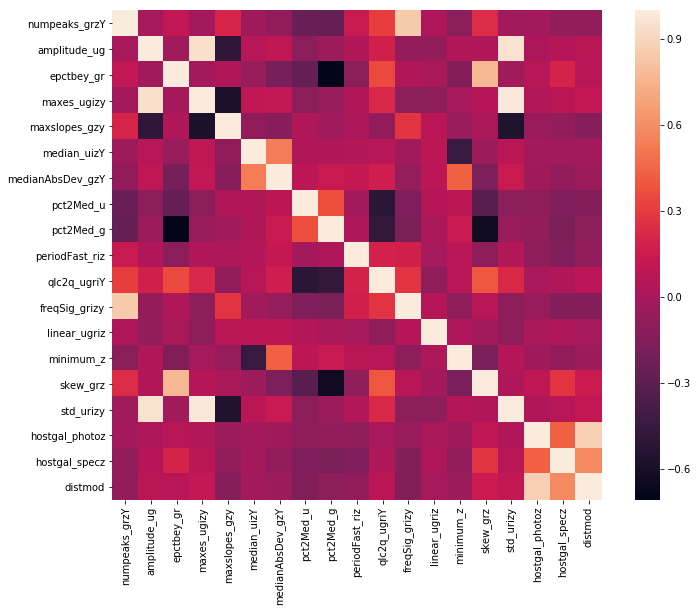

In [558]:
cor = egalfeats.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, square=True)
plt.show()

In [559]:
#Split X,Y
egalX = egalfeats
egalY = extragal['target']


#Create Train/Test splits
egalX_train, egalX_test, egalY_train, egalY_test = train_test_split(
    egalX, egalY, test_size=0.5)


egalknn = KNeighborsClassifier(n_neighbors=15, weights='distance')
egalknn.fit(egalX_train, egalY_train)

egalknn.score(egalX_test, egalY_test)

0.5528602461984069